In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/eriklindernoren/PyTorch-GAN

Cloning into 'PyTorch-GAN'...
remote: Enumerating objects: 1283, done.
remote: Total 1283 (delta 0), reused 0 (delta 0), pack-reused 1283 (from 1)
Receiving objects: 100% (1283/1283), 68.04 MiB | 42.59 MiB/s, done.
Resolving deltas: 100% (751/751), done.


In [3]:
%cd PyTorch-GAN

/content/PyTorch-GAN


In [4]:
!ls

assets	data  implementations  LICENSE	README.md  requirements.txt


In [5]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   30G   84G  26% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.2G  820M  59% /usr/sbin/docker-init
/dev/sda1        92G   63G   30G  69% /opt/bin/.nvidia
tmpfs           6.4G   88K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive           113G   34G   80G  30% /content/drive


In [6]:

pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [7]:
%cd implementations/acgan/

/content/PyTorch-GAN/implementations/acgan


In [23]:
def poison_dataset(dataset, poison_ratio=0.2):
    """
    Function to poison the dataset by changing a percentage of random samples
    to have a random label.

    Args:
        dataset: The dataset to be poisoned (assumed to be torchvision dataset).
        poison_ratio: The ratio of samples that should have a randomly changed label.

    Returns:
        poisoned_dataset: The poisoned version of the dataset.
    """
    num_samples = len(dataset)
    num_poisoned_samples = int(num_samples * poison_ratio)
    poisoned_indices = np.random.choice(num_samples, num_poisoned_samples, replace=False)

    poisoned_dataset = []
    for i in range(num_samples):
        img, label = dataset[i]
        if i in poisoned_indices:
            label = np.random.choice([l for l in range(10) if l != label])  # Avoid keeping the same label
        poisoned_dataset.append((img, label))

    return poisoned_dataset


In [24]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
# Configure data loader
os.makedirs("../../data/CIFAR10", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=50, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=256, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=16, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--n_classes", type=int, default=10, help="number of classes for dataset")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=3, help="number of image channels") # changed channels to 3 for rgb image
parser.add_argument("--sample_interval", type=int, default=200, help="interval between image sampling")

opt = parser.parse_args([]) # remove arguments from this list if you do intend to pass arguments

# Load the original MNIST dataset
original_dataset = datasets.CIFAR10(
    "../../data/CIFAR10",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    ),
)


Files already downloaded and verified


For compound atk

In [26]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import random

# Load CIFAR-10 dataset
transform = transforms.ToTensor()
cifar_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Function to add Gaussian noise to an image
def add_gaussian_noise(image, mean=0, max_std=0):
    std = random.uniform(0, max_std)
    noise = torch.randn(image.size()) * std + mean
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0., 1.)

# Apply Gaussian noise to 30% of the CIFAR-10 dataset
num_noisy_samples = int(1 * len(cifar_data))
random_indices = np.random.choice(len(cifar_data), num_noisy_samples, replace=False)

modified_images = []
for idx in range(len(cifar_data)):
    image, label = cifar_data[idx]
    if idx in random_indices:
        image = add_gaussian_noise(image)
    modified_images.append((image, label))

# Apply label flipping attack to the noisy dataset
poisoned_dataset = poison_dataset(modified_images, poison_ratio=0.8)

# Convert to TensorDataset for DataLoader
label_dataset = TensorDataset(
    torch.stack([img for img, _ in poisoned_dataset]),
    torch.tensor([lbl for _, lbl in poisoned_dataset])
)


Files already downloaded and verified


For Outliers

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import random

# Load CIFAR-10 dataset
transform = transforms.ToTensor()
cifar_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

class OutlierInjectedCIFAR(torch.utils.data.Dataset):
    def __init__(self, dataset, outlier_fraction=0.2):
        """
        Outlier injection attack by replacing a fraction of CIFAR-10 images with random noise.

        Args:
            dataset: Original CIFAR-10 dataset.
            outlier_fraction: Fraction of dataset to replace with random noise (default: 20%).
        """
        self.dataset = dataset
        self.outlier_fraction = outlier_fraction
        self.outlier_indices = set()
        self.inject_outliers()

    def inject_outliers(self):
        """Injects random noise images as outliers into the dataset."""
        num_outliers = int(self.outlier_fraction * len(self.dataset))
        outlier_indices = np.random.choice(len(self.dataset), num_outliers, replace=False)
        self.outlier_indices = set(outlier_indices)

        for idx in outlier_indices:
            # Generate a completely random noise image
            random_image = torch.randn((3, 32, 32))  # CIFAR-10 has 3 channels, 32x32 size

            # Assign a random label (not necessarily related to real classes)
            random_label = np.random.randint(0, 10)

            # Replace original sample with outlier
            self.dataset.data[idx] = (random_image.permute(1, 2, 0) * 255).byte().numpy()
            self.dataset.targets[idx] = random_label

    def __getitem__(self, index):
        return self.dataset[index]

    def __len__(self):
        return len(self.dataset)

# Apply outlier injection attack (e.g., 20% of images replaced with random noise)
poisoned_dataset = OutlierInjectedCIFAR(cifar_data, outlier_fraction=0.2)

# Convert to TensorDataset for DataLoader
final_dataset = TensorDataset(
    torch.tensor(poisoned_dataset.dataset.data).permute(0, 3, 1, 2).float() / 255,
    torch.tensor(poisoned_dataset.dataset.targets)
)

dataloader_outlier = DataLoader(final_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)


100%|██████████| 170M/170M [00:04<00:00, 38.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


For Original Performance

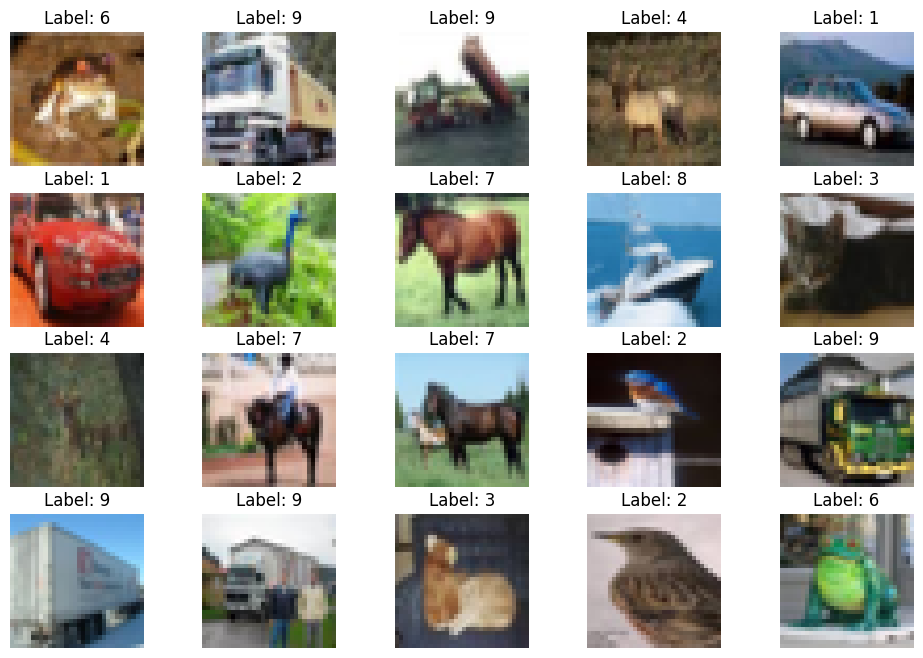

In [ ]:
dataloader = DataLoader(cifar_data, batch_size=64, shuffle=True)

# Plot some noisy and non-noisy images for verification
fig, axes = plt.subplots(4, 5, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()):
    image, label = cifar_data[i]
    ax.imshow(image.permute(1, 2, 0).numpy())  # Convert tensor to NumPy array and rearrange dimensions
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.show()


For Gaussian + label atk performance

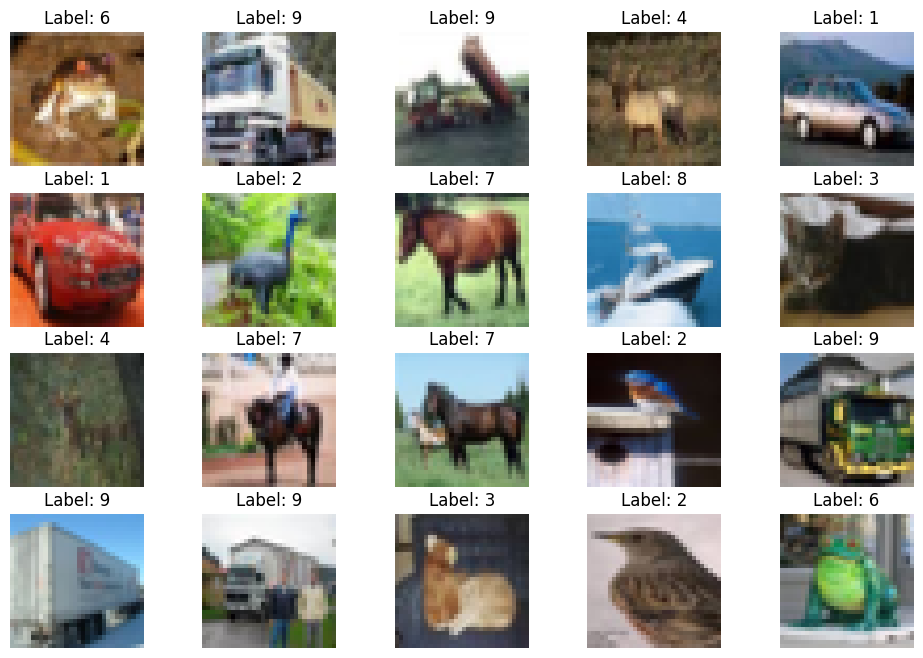

In [29]:
dataloader1 = DataLoader(label_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
# Plot some noisy and non-noisy images for verification
fig, axes = plt.subplots(4, 5, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()):
    image, label = modified_images[i]
    ax.imshow(image.permute(1, 2, 0).numpy())  # Convert tensor to NumPy array and rearrange dimensions
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.show()


In [30]:
print(opt)
cuda = True if torch.cuda.is_available() else False

# Move FloatTensor and LongTensor definitions here
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(opt.n_classes, opt.latent_dim)

        self.init_size = opt.img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, opt.n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label


# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)

    # Create the 'images' directory if it doesn't exist
    os.makedirs("images", exist_ok=True)

    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)



Namespace(n_epochs=50, batch_size=256, lr=0.0002, b1=0.5, b2=0.999, n_cpu=16, latent_dim=100, n_classes=10, img_size=32, channels=3, sample_interval=200)


In [31]:

# ----------
#  Training
# ----------

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Track metrics
g_losses, d_losses, d_accuracies = [], [], []
epoch_confusion_matrices = []

for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader_outlier):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = discriminator(gen_imgs)
        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optimizer_D.step()

        # Store metrics for visualization
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        d_accuracies.append(d_acc * 100)

        if i == len(dataloader_outlier) - 1:
            cm = confusion_matrix(gt, np.argmax(pred, axis=1))
            epoch_confusion_matrices.append(cm)

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader_outlier), d_loss.item(), 100 * d_acc, g_loss.item())
        )
        batches_done = epoch * len(dataloader_outlier) + i
        if batches_done % opt.sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 0/50] [Batch 0/196] [D loss: 1.497879, acc: 11%] [G loss: 1.489567]
[Epoch 0/50] [Batch 1/196] [D loss: 1.498006, acc: 7%] [G loss: 1.490112]
[Epoch 0/50] [Batch 2/196] [D loss: 1.497876, acc: 10%] [G loss: 1.490133]
[Epoch 0/50] [Batch 3/196] [D loss: 1.497904, acc: 8%] [G loss: 1.490646]
[Epoch 0/50] [Batch 4/196] [D loss: 1.497878, acc: 11%] [G loss: 1.490720]
[Epoch 0/50] [Batch 5/196] [D loss: 1.497977, acc: 9%] [G loss: 1.491025]
[Epoch 0/50] [Batch 6/196] [D loss: 1.497881, acc: 8%] [G loss: 1.491208]
[Epoch 0/50] [Batch 7/196] [D loss: 1.497800, acc: 10%] [G loss: 1.491436]
[Epoch 0/50] [Batch 8/196] [D loss: 1.497889, acc: 8%] [G loss: 1.491810]
[Epoch 0/50] [Batch 9/196] [D loss: 1.497733, acc: 9%] [G loss: 1.491910]
[Epoch 0/50] [Batch 10/196] [D loss: 1.497735, acc: 8%] [G loss: 1.491894]
[Epoch 0/50] [Batch 11/196] [D loss: 1.497647, acc: 12%] [G loss: 1.492218]
[Epoch 0/50] [Batch 12/196] [D loss: 1.497735, acc: 8%] [G loss: 1.492428]
[Epoch 0/50] [Batch 13/196] [D

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 1/50] [Batch 0/196] [D loss: 1.498823, acc: 8%] [G loss: 1.494611]
[Epoch 1/50] [Batch 1/196] [D loss: 1.498732, acc: 10%] [G loss: 1.494078]
[Epoch 1/50] [Batch 2/196] [D loss: 1.498249, acc: 9%] [G loss: 1.493504]
[Epoch 1/50] [Batch 3/196] [D loss: 1.498011, acc: 10%] [G loss: 1.493255]
[Epoch 1/50] [Batch 4/196] [D loss: 1.497642, acc: 9%] [G loss: 1.493264]
[Epoch 1/50] [Batch 5/196] [D loss: 1.497313, acc: 11%] [G loss: 1.493555]
[Epoch 1/50] [Batch 6/196] [D loss: 1.497458, acc: 9%] [G loss: 1.493848]
[Epoch 1/50] [Batch 7/196] [D loss: 1.497400, acc: 8%] [G loss: 1.494189]
[Epoch 1/50] [Batch 8/196] [D loss: 1.497469, acc: 12%] [G loss: 1.493953]
[Epoch 1/50] [Batch 9/196] [D loss: 1.497714, acc: 8%] [G loss: 1.494087]
[Epoch 1/50] [Batch 10/196] [D loss: 1.497465, acc: 10%] [G loss: 1.494570]
[Epoch 1/50] [Batch 11/196] [D loss: 1.497477, acc: 9%] [G loss: 1.494561]
[Epoch 1/50] [Batch 12/196] [D loss: 1.497742, acc: 8%] [G loss: 1.494720]
[Epoch 1/50] [Batch 13/196] [D

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 2/50] [Batch 0/196] [D loss: 1.498346, acc: 10%] [G loss: 1.496418]
[Epoch 2/50] [Batch 1/196] [D loss: 1.497792, acc: 12%] [G loss: 1.496063]
[Epoch 2/50] [Batch 2/196] [D loss: 1.498031, acc: 10%] [G loss: 1.496105]
[Epoch 2/50] [Batch 3/196] [D loss: 1.498056, acc: 9%] [G loss: 1.496407]
[Epoch 2/50] [Batch 4/196] [D loss: 1.497688, acc: 9%] [G loss: 1.496310]
[Epoch 2/50] [Batch 5/196] [D loss: 1.497909, acc: 10%] [G loss: 1.496541]
[Epoch 2/50] [Batch 6/196] [D loss: 1.497652, acc: 11%] [G loss: 1.497102]
[Epoch 2/50] [Batch 7/196] [D loss: 1.497712, acc: 9%] [G loss: 1.497009]
[Epoch 2/50] [Batch 8/196] [D loss: 1.497830, acc: 11%] [G loss: 1.496697]
[Epoch 2/50] [Batch 9/196] [D loss: 1.497830, acc: 9%] [G loss: 1.497216]
[Epoch 2/50] [Batch 10/196] [D loss: 1.497699, acc: 10%] [G loss: 1.497412]
[Epoch 2/50] [Batch 11/196] [D loss: 1.497994, acc: 9%] [G loss: 1.497662]
[Epoch 2/50] [Batch 12/196] [D loss: 1.497987, acc: 10%] [G loss: 1.497581]
[Epoch 2/50] [Batch 13/196]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 3/50] [Batch 0/196] [D loss: 1.498654, acc: 9%] [G loss: 1.497028]
[Epoch 3/50] [Batch 1/196] [D loss: 1.498871, acc: 11%] [G loss: 1.496805]
[Epoch 3/50] [Batch 2/196] [D loss: 1.499029, acc: 12%] [G loss: 1.495329]
[Epoch 3/50] [Batch 3/196] [D loss: 1.498771, acc: 9%] [G loss: 1.495134]
[Epoch 3/50] [Batch 4/196] [D loss: 1.498513, acc: 10%] [G loss: 1.496249]
[Epoch 3/50] [Batch 5/196] [D loss: 1.497681, acc: 11%] [G loss: 1.496786]
[Epoch 3/50] [Batch 6/196] [D loss: 1.496616, acc: 12%] [G loss: 1.498856]
[Epoch 3/50] [Batch 7/196] [D loss: 1.495782, acc: 11%] [G loss: 1.499788]
[Epoch 3/50] [Batch 8/196] [D loss: 1.494894, acc: 13%] [G loss: 1.499318]
[Epoch 3/50] [Batch 9/196] [D loss: 1.495723, acc: 11%] [G loss: 1.498876]
[Epoch 3/50] [Batch 10/196] [D loss: 1.496433, acc: 11%] [G loss: 1.496792]
[Epoch 3/50] [Batch 11/196] [D loss: 1.497113, acc: 9%] [G loss: 1.495334]
[Epoch 3/50] [Batch 12/196] [D loss: 1.497949, acc: 10%] [G loss: 1.494346]
[Epoch 3/50] [Batch 13/19

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 4/50] [Batch 0/196] [D loss: 1.427665, acc: 27%] [G loss: 1.393892]
[Epoch 4/50] [Batch 1/196] [D loss: 1.421531, acc: 29%] [G loss: 1.383609]
[Epoch 4/50] [Batch 2/196] [D loss: 1.432847, acc: 27%] [G loss: 1.394465]
[Epoch 4/50] [Batch 3/196] [D loss: 1.415344, acc: 30%] [G loss: 1.380345]
[Epoch 4/50] [Batch 4/196] [D loss: 1.409339, acc: 31%] [G loss: 1.377125]
[Epoch 4/50] [Batch 5/196] [D loss: 1.429758, acc: 25%] [G loss: 1.394106]
[Epoch 4/50] [Batch 6/196] [D loss: 1.419171, acc: 28%] [G loss: 1.390278]
[Epoch 4/50] [Batch 7/196] [D loss: 1.417074, acc: 29%] [G loss: 1.366632]
[Epoch 4/50] [Batch 8/196] [D loss: 1.417785, acc: 29%] [G loss: 1.346286]
[Epoch 4/50] [Batch 9/196] [D loss: 1.432880, acc: 25%] [G loss: 1.380731]
[Epoch 4/50] [Batch 10/196] [D loss: 1.418248, acc: 28%] [G loss: 1.359075]
[Epoch 4/50] [Batch 11/196] [D loss: 1.413751, acc: 29%] [G loss: 1.366186]
[Epoch 4/50] [Batch 12/196] [D loss: 1.411760, acc: 28%] [G loss: 1.372468]
[Epoch 4/50] [Batch 13

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 5/50] [Batch 0/196] [D loss: 1.332455, acc: 50%] [G loss: 1.188357]
[Epoch 5/50] [Batch 1/196] [D loss: 1.347509, acc: 48%] [G loss: 1.217266]
[Epoch 5/50] [Batch 2/196] [D loss: 1.342492, acc: 48%] [G loss: 1.211914]
[Epoch 5/50] [Batch 3/196] [D loss: 1.310390, acc: 53%] [G loss: 1.222908]
[Epoch 5/50] [Batch 4/196] [D loss: 1.316127, acc: 49%] [G loss: 1.238454]
[Epoch 5/50] [Batch 5/196] [D loss: 1.321580, acc: 49%] [G loss: 1.240468]
[Epoch 5/50] [Batch 6/196] [D loss: 1.313699, acc: 51%] [G loss: 1.218686]
[Epoch 5/50] [Batch 7/196] [D loss: 1.296561, acc: 52%] [G loss: 1.213446]
[Epoch 5/50] [Batch 8/196] [D loss: 1.311155, acc: 51%] [G loss: 1.218089]
[Epoch 5/50] [Batch 9/196] [D loss: 1.305814, acc: 54%] [G loss: 1.204200]
[Epoch 5/50] [Batch 10/196] [D loss: 1.299305, acc: 54%] [G loss: 1.197366]
[Epoch 5/50] [Batch 11/196] [D loss: 1.317647, acc: 49%] [G loss: 1.207733]
[Epoch 5/50] [Batch 12/196] [D loss: 1.307378, acc: 52%] [G loss: 1.176560]
[Epoch 5/50] [Batch 13

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 6/50] [Batch 0/196] [D loss: 1.269485, acc: 58%] [G loss: 1.150191]
[Epoch 6/50] [Batch 1/196] [D loss: 1.263835, acc: 60%] [G loss: 1.125496]
[Epoch 6/50] [Batch 2/196] [D loss: 1.279647, acc: 57%] [G loss: 1.115479]
[Epoch 6/50] [Batch 3/196] [D loss: 1.281871, acc: 55%] [G loss: 1.142283]
[Epoch 6/50] [Batch 4/196] [D loss: 1.285095, acc: 56%] [G loss: 1.139239]
[Epoch 6/50] [Batch 5/196] [D loss: 1.280068, acc: 55%] [G loss: 1.147198]
[Epoch 6/50] [Batch 6/196] [D loss: 1.277158, acc: 55%] [G loss: 1.155621]
[Epoch 6/50] [Batch 7/196] [D loss: 1.276002, acc: 57%] [G loss: 1.165540]
[Epoch 6/50] [Batch 8/196] [D loss: 1.276191, acc: 56%] [G loss: 1.177659]
[Epoch 6/50] [Batch 9/196] [D loss: 1.269673, acc: 57%] [G loss: 1.173781]
[Epoch 6/50] [Batch 10/196] [D loss: 1.271402, acc: 58%] [G loss: 1.190610]
[Epoch 6/50] [Batch 11/196] [D loss: 1.267938, acc: 56%] [G loss: 1.191741]
[Epoch 6/50] [Batch 12/196] [D loss: 1.271042, acc: 55%] [G loss: 1.173128]
[Epoch 6/50] [Batch 13

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 7/50] [Batch 0/196] [D loss: 1.244433, acc: 58%] [G loss: 1.202867]
[Epoch 7/50] [Batch 1/196] [D loss: 1.258908, acc: 55%] [G loss: 1.212841]
[Epoch 7/50] [Batch 2/196] [D loss: 1.254879, acc: 58%] [G loss: 1.196857]
[Epoch 7/50] [Batch 3/196] [D loss: 1.251362, acc: 59%] [G loss: 1.163455]
[Epoch 7/50] [Batch 4/196] [D loss: 1.258615, acc: 55%] [G loss: 1.173228]
[Epoch 7/50] [Batch 5/196] [D loss: 1.283614, acc: 55%] [G loss: 1.154272]
[Epoch 7/50] [Batch 6/196] [D loss: 1.275182, acc: 59%] [G loss: 1.142750]
[Epoch 7/50] [Batch 7/196] [D loss: 1.270434, acc: 59%] [G loss: 1.173089]
[Epoch 7/50] [Batch 8/196] [D loss: 1.273963, acc: 57%] [G loss: 1.158535]
[Epoch 7/50] [Batch 9/196] [D loss: 1.251250, acc: 62%] [G loss: 1.145695]
[Epoch 7/50] [Batch 10/196] [D loss: 1.247065, acc: 58%] [G loss: 1.167287]
[Epoch 7/50] [Batch 11/196] [D loss: 1.247028, acc: 58%] [G loss: 1.153615]
[Epoch 7/50] [Batch 12/196] [D loss: 1.258839, acc: 59%] [G loss: 1.170219]
[Epoch 7/50] [Batch 13

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 8/50] [Batch 0/196] [D loss: 1.265797, acc: 58%] [G loss: 1.174775]
[Epoch 8/50] [Batch 1/196] [D loss: 1.272599, acc: 55%] [G loss: 1.190715]
[Epoch 8/50] [Batch 2/196] [D loss: 1.259920, acc: 57%] [G loss: 1.170336]
[Epoch 8/50] [Batch 3/196] [D loss: 1.260928, acc: 58%] [G loss: 1.181105]
[Epoch 8/50] [Batch 4/196] [D loss: 1.261675, acc: 58%] [G loss: 1.186796]
[Epoch 8/50] [Batch 5/196] [D loss: 1.275311, acc: 57%] [G loss: 1.162288]
[Epoch 8/50] [Batch 6/196] [D loss: 1.263797, acc: 56%] [G loss: 1.171283]
[Epoch 8/50] [Batch 7/196] [D loss: 1.274224, acc: 58%] [G loss: 1.195818]
[Epoch 8/50] [Batch 8/196] [D loss: 1.252600, acc: 60%] [G loss: 1.180153]
[Epoch 8/50] [Batch 9/196] [D loss: 1.260135, acc: 59%] [G loss: 1.184930]
[Epoch 8/50] [Batch 10/196] [D loss: 1.244808, acc: 57%] [G loss: 1.180645]
[Epoch 8/50] [Batch 11/196] [D loss: 1.263069, acc: 58%] [G loss: 1.199032]
[Epoch 8/50] [Batch 12/196] [D loss: 1.260530, acc: 58%] [G loss: 1.161192]
[Epoch 8/50] [Batch 13

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 9/50] [Batch 0/196] [D loss: 1.263788, acc: 58%] [G loss: 1.166984]
[Epoch 9/50] [Batch 1/196] [D loss: 1.253264, acc: 59%] [G loss: 1.152119]
[Epoch 9/50] [Batch 2/196] [D loss: 1.261510, acc: 57%] [G loss: 1.168423]
[Epoch 9/50] [Batch 3/196] [D loss: 1.271251, acc: 58%] [G loss: 1.140350]
[Epoch 9/50] [Batch 4/196] [D loss: 1.294343, acc: 55%] [G loss: 1.145766]
[Epoch 9/50] [Batch 5/196] [D loss: 1.259671, acc: 58%] [G loss: 1.148997]
[Epoch 9/50] [Batch 6/196] [D loss: 1.252861, acc: 60%] [G loss: 1.162521]
[Epoch 9/50] [Batch 7/196] [D loss: 1.238541, acc: 60%] [G loss: 1.149682]
[Epoch 9/50] [Batch 8/196] [D loss: 1.249253, acc: 58%] [G loss: 1.151078]
[Epoch 9/50] [Batch 9/196] [D loss: 1.264812, acc: 58%] [G loss: 1.164271]
[Epoch 9/50] [Batch 10/196] [D loss: 1.255348, acc: 58%] [G loss: 1.166353]
[Epoch 9/50] [Batch 11/196] [D loss: 1.256960, acc: 57%] [G loss: 1.163388]
[Epoch 9/50] [Batch 12/196] [D loss: 1.254744, acc: 59%] [G loss: 1.167825]
[Epoch 9/50] [Batch 13

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 10/50] [Batch 0/196] [D loss: 1.276670, acc: 58%] [G loss: 1.179052]
[Epoch 10/50] [Batch 1/196] [D loss: 1.278747, acc: 58%] [G loss: 1.158531]
[Epoch 10/50] [Batch 2/196] [D loss: 1.271176, acc: 58%] [G loss: 1.146021]
[Epoch 10/50] [Batch 3/196] [D loss: 1.289782, acc: 59%] [G loss: 1.137848]
[Epoch 10/50] [Batch 4/196] [D loss: 1.285338, acc: 59%] [G loss: 1.122735]
[Epoch 10/50] [Batch 5/196] [D loss: 1.272143, acc: 57%] [G loss: 1.148693]
[Epoch 10/50] [Batch 6/196] [D loss: 1.277040, acc: 58%] [G loss: 1.125995]
[Epoch 10/50] [Batch 7/196] [D loss: 1.274328, acc: 59%] [G loss: 1.129524]
[Epoch 10/50] [Batch 8/196] [D loss: 1.272891, acc: 58%] [G loss: 1.159268]
[Epoch 10/50] [Batch 9/196] [D loss: 1.268097, acc: 60%] [G loss: 1.157326]
[Epoch 10/50] [Batch 10/196] [D loss: 1.265966, acc: 59%] [G loss: 1.139322]
[Epoch 10/50] [Batch 11/196] [D loss: 1.259540, acc: 59%] [G loss: 1.150597]
[Epoch 10/50] [Batch 12/196] [D loss: 1.265258, acc: 59%] [G loss: 1.147140]
[Epoch 10

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 11/50] [Batch 0/196] [D loss: 1.267387, acc: 58%] [G loss: 1.122442]
[Epoch 11/50] [Batch 1/196] [D loss: 1.268754, acc: 59%] [G loss: 1.143956]
[Epoch 11/50] [Batch 2/196] [D loss: 1.273276, acc: 59%] [G loss: 1.127185]
[Epoch 11/50] [Batch 3/196] [D loss: 1.278139, acc: 60%] [G loss: 1.134196]
[Epoch 11/50] [Batch 4/196] [D loss: 1.261495, acc: 59%] [G loss: 1.137238]
[Epoch 11/50] [Batch 5/196] [D loss: 1.274426, acc: 58%] [G loss: 1.138056]
[Epoch 11/50] [Batch 6/196] [D loss: 1.265471, acc: 60%] [G loss: 1.141007]
[Epoch 11/50] [Batch 7/196] [D loss: 1.253268, acc: 59%] [G loss: 1.144020]
[Epoch 11/50] [Batch 8/196] [D loss: 1.259466, acc: 60%] [G loss: 1.138724]
[Epoch 11/50] [Batch 9/196] [D loss: 1.262239, acc: 58%] [G loss: 1.113060]
[Epoch 11/50] [Batch 10/196] [D loss: 1.266979, acc: 62%] [G loss: 1.118114]
[Epoch 11/50] [Batch 11/196] [D loss: 1.279791, acc: 59%] [G loss: 1.151085]
[Epoch 11/50] [Batch 12/196] [D loss: 1.271121, acc: 59%] [G loss: 1.128074]
[Epoch 11

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 12/50] [Batch 0/196] [D loss: 1.273439, acc: 59%] [G loss: 1.170280]
[Epoch 12/50] [Batch 1/196] [D loss: 1.276075, acc: 58%] [G loss: 1.160329]
[Epoch 12/50] [Batch 2/196] [D loss: 1.254759, acc: 58%] [G loss: 1.140964]
[Epoch 12/50] [Batch 3/196] [D loss: 1.276433, acc: 56%] [G loss: 1.158343]
[Epoch 12/50] [Batch 4/196] [D loss: 1.260435, acc: 60%] [G loss: 1.133132]
[Epoch 12/50] [Batch 5/196] [D loss: 1.257649, acc: 60%] [G loss: 1.135409]
[Epoch 12/50] [Batch 6/196] [D loss: 1.255566, acc: 58%] [G loss: 1.159624]
[Epoch 12/50] [Batch 7/196] [D loss: 1.255349, acc: 62%] [G loss: 1.125121]
[Epoch 12/50] [Batch 8/196] [D loss: 1.261635, acc: 58%] [G loss: 1.157872]
[Epoch 12/50] [Batch 9/196] [D loss: 1.261428, acc: 59%] [G loss: 1.140131]
[Epoch 12/50] [Batch 10/196] [D loss: 1.260961, acc: 58%] [G loss: 1.149303]
[Epoch 12/50] [Batch 11/196] [D loss: 1.260614, acc: 60%] [G loss: 1.130757]
[Epoch 12/50] [Batch 12/196] [D loss: 1.247890, acc: 59%] [G loss: 1.158055]
[Epoch 12

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 13/50] [Batch 0/196] [D loss: 1.264299, acc: 59%] [G loss: 1.166263]
[Epoch 13/50] [Batch 1/196] [D loss: 1.248786, acc: 58%] [G loss: 1.137784]
[Epoch 13/50] [Batch 2/196] [D loss: 1.256086, acc: 59%] [G loss: 1.134937]
[Epoch 13/50] [Batch 3/196] [D loss: 1.261840, acc: 60%] [G loss: 1.116523]
[Epoch 13/50] [Batch 4/196] [D loss: 1.264387, acc: 59%] [G loss: 1.140545]
[Epoch 13/50] [Batch 5/196] [D loss: 1.255737, acc: 61%] [G loss: 1.122255]
[Epoch 13/50] [Batch 6/196] [D loss: 1.245845, acc: 59%] [G loss: 1.127402]
[Epoch 13/50] [Batch 7/196] [D loss: 1.250333, acc: 60%] [G loss: 1.138320]
[Epoch 13/50] [Batch 8/196] [D loss: 1.260925, acc: 62%] [G loss: 1.128397]
[Epoch 13/50] [Batch 9/196] [D loss: 1.261176, acc: 59%] [G loss: 1.139404]
[Epoch 13/50] [Batch 10/196] [D loss: 1.236485, acc: 63%] [G loss: 1.120165]
[Epoch 13/50] [Batch 11/196] [D loss: 1.254998, acc: 60%] [G loss: 1.117888]
[Epoch 13/50] [Batch 12/196] [D loss: 1.259633, acc: 59%] [G loss: 1.154828]
[Epoch 13

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 14/50] [Batch 0/196] [D loss: 1.240946, acc: 59%] [G loss: 1.155868]
[Epoch 14/50] [Batch 1/196] [D loss: 1.243102, acc: 58%] [G loss: 1.225802]
[Epoch 14/50] [Batch 2/196] [D loss: 1.255763, acc: 57%] [G loss: 1.166957]
[Epoch 14/50] [Batch 3/196] [D loss: 1.219003, acc: 65%] [G loss: 1.147357]
[Epoch 14/50] [Batch 4/196] [D loss: 1.255275, acc: 61%] [G loss: 1.144616]
[Epoch 14/50] [Batch 5/196] [D loss: 1.238137, acc: 62%] [G loss: 1.159770]
[Epoch 14/50] [Batch 6/196] [D loss: 1.248408, acc: 60%] [G loss: 1.151523]
[Epoch 14/50] [Batch 7/196] [D loss: 1.235259, acc: 60%] [G loss: 1.178964]
[Epoch 14/50] [Batch 8/196] [D loss: 1.248313, acc: 60%] [G loss: 1.153359]
[Epoch 14/50] [Batch 9/196] [D loss: 1.229905, acc: 59%] [G loss: 1.152586]
[Epoch 14/50] [Batch 10/196] [D loss: 1.244576, acc: 62%] [G loss: 1.142410]
[Epoch 14/50] [Batch 11/196] [D loss: 1.244363, acc: 59%] [G loss: 1.167457]
[Epoch 14/50] [Batch 12/196] [D loss: 1.261611, acc: 59%] [G loss: 1.159503]
[Epoch 14

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 15/50] [Batch 0/196] [D loss: 1.246949, acc: 59%] [G loss: 1.136965]
[Epoch 15/50] [Batch 1/196] [D loss: 1.255024, acc: 62%] [G loss: 1.130101]
[Epoch 15/50] [Batch 2/196] [D loss: 1.244183, acc: 63%] [G loss: 1.152281]
[Epoch 15/50] [Batch 3/196] [D loss: 1.235054, acc: 62%] [G loss: 1.173508]
[Epoch 15/50] [Batch 4/196] [D loss: 1.257295, acc: 61%] [G loss: 1.153711]
[Epoch 15/50] [Batch 5/196] [D loss: 1.246910, acc: 60%] [G loss: 1.138819]
[Epoch 15/50] [Batch 6/196] [D loss: 1.261426, acc: 60%] [G loss: 1.131712]
[Epoch 15/50] [Batch 7/196] [D loss: 1.241281, acc: 58%] [G loss: 1.164731]
[Epoch 15/50] [Batch 8/196] [D loss: 1.270431, acc: 60%] [G loss: 1.090810]
[Epoch 15/50] [Batch 9/196] [D loss: 1.251463, acc: 62%] [G loss: 1.132749]
[Epoch 15/50] [Batch 10/196] [D loss: 1.261018, acc: 59%] [G loss: 1.157866]
[Epoch 15/50] [Batch 11/196] [D loss: 1.252548, acc: 61%] [G loss: 1.136935]
[Epoch 15/50] [Batch 12/196] [D loss: 1.244205, acc: 61%] [G loss: 1.135351]
[Epoch 15

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 16/50] [Batch 0/196] [D loss: 1.235849, acc: 61%] [G loss: 1.217986]
[Epoch 16/50] [Batch 1/196] [D loss: 1.237361, acc: 62%] [G loss: 1.132216]
[Epoch 16/50] [Batch 2/196] [D loss: 1.231902, acc: 62%] [G loss: 1.184896]
[Epoch 16/50] [Batch 3/196] [D loss: 1.230496, acc: 62%] [G loss: 1.175991]
[Epoch 16/50] [Batch 4/196] [D loss: 1.262161, acc: 58%] [G loss: 1.170005]
[Epoch 16/50] [Batch 5/196] [D loss: 1.253850, acc: 60%] [G loss: 1.104981]
[Epoch 16/50] [Batch 6/196] [D loss: 1.258765, acc: 60%] [G loss: 1.110403]
[Epoch 16/50] [Batch 7/196] [D loss: 1.229107, acc: 62%] [G loss: 1.115101]
[Epoch 16/50] [Batch 8/196] [D loss: 1.239782, acc: 60%] [G loss: 1.137539]
[Epoch 16/50] [Batch 9/196] [D loss: 1.262590, acc: 59%] [G loss: 1.165708]
[Epoch 16/50] [Batch 10/196] [D loss: 1.237633, acc: 59%] [G loss: 1.140911]
[Epoch 16/50] [Batch 11/196] [D loss: 1.257852, acc: 59%] [G loss: 1.244154]
[Epoch 16/50] [Batch 12/196] [D loss: 1.227112, acc: 60%] [G loss: 1.244636]
[Epoch 16

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 17/50] [Batch 0/196] [D loss: 1.293905, acc: 59%] [G loss: 1.116666]
[Epoch 17/50] [Batch 1/196] [D loss: 1.252472, acc: 61%] [G loss: 1.079430]
[Epoch 17/50] [Batch 2/196] [D loss: 1.235899, acc: 60%] [G loss: 1.148585]
[Epoch 17/50] [Batch 3/196] [D loss: 1.241830, acc: 58%] [G loss: 1.153208]
[Epoch 17/50] [Batch 4/196] [D loss: 1.270655, acc: 58%] [G loss: 1.150513]
[Epoch 17/50] [Batch 5/196] [D loss: 1.248502, acc: 61%] [G loss: 1.138466]
[Epoch 17/50] [Batch 6/196] [D loss: 1.242131, acc: 63%] [G loss: 1.097785]
[Epoch 17/50] [Batch 7/196] [D loss: 1.262525, acc: 59%] [G loss: 1.177781]
[Epoch 17/50] [Batch 8/196] [D loss: 1.253557, acc: 60%] [G loss: 1.134867]
[Epoch 17/50] [Batch 9/196] [D loss: 1.241675, acc: 62%] [G loss: 1.168230]
[Epoch 17/50] [Batch 10/196] [D loss: 1.247290, acc: 60%] [G loss: 1.218016]
[Epoch 17/50] [Batch 11/196] [D loss: 1.226045, acc: 62%] [G loss: 1.160073]
[Epoch 17/50] [Batch 12/196] [D loss: 1.243515, acc: 64%] [G loss: 1.154664]
[Epoch 17

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 18/50] [Batch 0/196] [D loss: 1.267815, acc: 61%] [G loss: 1.163393]
[Epoch 18/50] [Batch 1/196] [D loss: 1.211559, acc: 61%] [G loss: 1.093022]
[Epoch 18/50] [Batch 2/196] [D loss: 1.213979, acc: 62%] [G loss: 1.191149]
[Epoch 18/50] [Batch 3/196] [D loss: 1.225591, acc: 61%] [G loss: 1.243761]
[Epoch 18/50] [Batch 4/196] [D loss: 1.257436, acc: 61%] [G loss: 1.115589]
[Epoch 18/50] [Batch 5/196] [D loss: 1.205404, acc: 62%] [G loss: 1.170318]
[Epoch 18/50] [Batch 6/196] [D loss: 1.269113, acc: 60%] [G loss: 1.116411]
[Epoch 18/50] [Batch 7/196] [D loss: 1.243500, acc: 62%] [G loss: 1.095717]
[Epoch 18/50] [Batch 8/196] [D loss: 1.265139, acc: 60%] [G loss: 1.184756]
[Epoch 18/50] [Batch 9/196] [D loss: 1.242997, acc: 60%] [G loss: 1.150126]
[Epoch 18/50] [Batch 10/196] [D loss: 1.229577, acc: 59%] [G loss: 1.109486]
[Epoch 18/50] [Batch 11/196] [D loss: 1.229984, acc: 61%] [G loss: 1.121942]
[Epoch 18/50] [Batch 12/196] [D loss: 1.267841, acc: 61%] [G loss: 1.261296]
[Epoch 18

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 19/50] [Batch 0/196] [D loss: 1.234087, acc: 61%] [G loss: 1.250520]
[Epoch 19/50] [Batch 1/196] [D loss: 1.238591, acc: 61%] [G loss: 1.243105]
[Epoch 19/50] [Batch 2/196] [D loss: 1.234330, acc: 59%] [G loss: 1.144852]
[Epoch 19/50] [Batch 3/196] [D loss: 1.259013, acc: 61%] [G loss: 1.087155]
[Epoch 19/50] [Batch 4/196] [D loss: 1.237236, acc: 61%] [G loss: 1.163211]
[Epoch 19/50] [Batch 5/196] [D loss: 1.240551, acc: 62%] [G loss: 1.161124]
[Epoch 19/50] [Batch 6/196] [D loss: 1.256812, acc: 62%] [G loss: 1.109134]
[Epoch 19/50] [Batch 7/196] [D loss: 1.252829, acc: 58%] [G loss: 1.161581]
[Epoch 19/50] [Batch 8/196] [D loss: 1.220480, acc: 60%] [G loss: 1.180344]
[Epoch 19/50] [Batch 9/196] [D loss: 1.210046, acc: 64%] [G loss: 1.189870]
[Epoch 19/50] [Batch 10/196] [D loss: 1.220729, acc: 61%] [G loss: 1.164387]
[Epoch 19/50] [Batch 11/196] [D loss: 1.215291, acc: 61%] [G loss: 1.180779]
[Epoch 19/50] [Batch 12/196] [D loss: 1.257663, acc: 60%] [G loss: 1.165714]
[Epoch 19

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 20/50] [Batch 0/196] [D loss: 1.215188, acc: 62%] [G loss: 1.169387]
[Epoch 20/50] [Batch 1/196] [D loss: 1.239805, acc: 64%] [G loss: 1.146601]
[Epoch 20/50] [Batch 2/196] [D loss: 1.209530, acc: 62%] [G loss: 1.195474]
[Epoch 20/50] [Batch 3/196] [D loss: 1.245920, acc: 63%] [G loss: 1.225922]
[Epoch 20/50] [Batch 4/196] [D loss: 1.275995, acc: 60%] [G loss: 1.254688]
[Epoch 20/50] [Batch 5/196] [D loss: 1.252817, acc: 61%] [G loss: 1.167545]
[Epoch 20/50] [Batch 6/196] [D loss: 1.199534, acc: 60%] [G loss: 1.173767]
[Epoch 20/50] [Batch 7/196] [D loss: 1.242765, acc: 62%] [G loss: 1.152676]
[Epoch 20/50] [Batch 8/196] [D loss: 1.198002, acc: 62%] [G loss: 1.079453]
[Epoch 20/50] [Batch 9/196] [D loss: 1.267572, acc: 60%] [G loss: 1.159068]
[Epoch 20/50] [Batch 10/196] [D loss: 1.284609, acc: 60%] [G loss: 1.156426]
[Epoch 20/50] [Batch 11/196] [D loss: 1.250414, acc: 59%] [G loss: 1.091436]
[Epoch 20/50] [Batch 12/196] [D loss: 1.241940, acc: 61%] [G loss: 1.074644]
[Epoch 20

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 21/50] [Batch 0/196] [D loss: 1.231649, acc: 60%] [G loss: 1.391450]
[Epoch 21/50] [Batch 1/196] [D loss: 1.233045, acc: 62%] [G loss: 1.172563]
[Epoch 21/50] [Batch 2/196] [D loss: 1.237005, acc: 62%] [G loss: 1.114814]
[Epoch 21/50] [Batch 3/196] [D loss: 1.215801, acc: 60%] [G loss: 1.115006]
[Epoch 21/50] [Batch 4/196] [D loss: 1.235973, acc: 58%] [G loss: 1.142217]
[Epoch 21/50] [Batch 5/196] [D loss: 1.273323, acc: 60%] [G loss: 1.092972]
[Epoch 21/50] [Batch 6/196] [D loss: 1.233172, acc: 62%] [G loss: 1.130637]
[Epoch 21/50] [Batch 7/196] [D loss: 1.241589, acc: 61%] [G loss: 1.190331]
[Epoch 21/50] [Batch 8/196] [D loss: 1.275725, acc: 62%] [G loss: 1.140551]
[Epoch 21/50] [Batch 9/196] [D loss: 1.255977, acc: 58%] [G loss: 1.155351]
[Epoch 21/50] [Batch 10/196] [D loss: 1.200114, acc: 61%] [G loss: 1.206715]
[Epoch 21/50] [Batch 11/196] [D loss: 1.261867, acc: 61%] [G loss: 1.102654]
[Epoch 21/50] [Batch 12/196] [D loss: 1.234628, acc: 62%] [G loss: 1.159684]
[Epoch 21

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 22/50] [Batch 0/196] [D loss: 1.226138, acc: 61%] [G loss: 1.073471]
[Epoch 22/50] [Batch 1/196] [D loss: 1.282886, acc: 62%] [G loss: 1.010755]
[Epoch 22/50] [Batch 2/196] [D loss: 1.283972, acc: 62%] [G loss: 1.019878]
[Epoch 22/50] [Batch 3/196] [D loss: 1.224452, acc: 60%] [G loss: 1.169160]
[Epoch 22/50] [Batch 4/196] [D loss: 1.222389, acc: 61%] [G loss: 1.156445]
[Epoch 22/50] [Batch 5/196] [D loss: 1.257132, acc: 63%] [G loss: 1.087779]
[Epoch 22/50] [Batch 6/196] [D loss: 1.246170, acc: 63%] [G loss: 1.110796]
[Epoch 22/50] [Batch 7/196] [D loss: 1.209844, acc: 62%] [G loss: 1.183790]
[Epoch 22/50] [Batch 8/196] [D loss: 1.244467, acc: 64%] [G loss: 1.250341]
[Epoch 22/50] [Batch 9/196] [D loss: 1.222364, acc: 60%] [G loss: 1.333273]
[Epoch 22/50] [Batch 10/196] [D loss: 1.204818, acc: 62%] [G loss: 1.213377]
[Epoch 22/50] [Batch 11/196] [D loss: 1.205990, acc: 64%] [G loss: 1.122867]
[Epoch 22/50] [Batch 12/196] [D loss: 1.224363, acc: 61%] [G loss: 1.095630]
[Epoch 22

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 23/50] [Batch 0/196] [D loss: 1.261388, acc: 61%] [G loss: 1.083024]
[Epoch 23/50] [Batch 1/196] [D loss: 1.190866, acc: 62%] [G loss: 1.153085]
[Epoch 23/50] [Batch 2/196] [D loss: 1.270382, acc: 59%] [G loss: 1.157348]
[Epoch 23/50] [Batch 3/196] [D loss: 1.265799, acc: 62%] [G loss: 1.179371]
[Epoch 23/50] [Batch 4/196] [D loss: 1.253665, acc: 62%] [G loss: 1.101328]
[Epoch 23/50] [Batch 5/196] [D loss: 1.245950, acc: 61%] [G loss: 1.134378]
[Epoch 23/50] [Batch 6/196] [D loss: 1.227493, acc: 63%] [G loss: 1.212883]
[Epoch 23/50] [Batch 7/196] [D loss: 1.237783, acc: 62%] [G loss: 1.209788]
[Epoch 23/50] [Batch 8/196] [D loss: 1.263840, acc: 62%] [G loss: 1.059983]
[Epoch 23/50] [Batch 9/196] [D loss: 1.265070, acc: 59%] [G loss: 1.186285]
[Epoch 23/50] [Batch 10/196] [D loss: 1.269530, acc: 61%] [G loss: 1.176919]
[Epoch 23/50] [Batch 11/196] [D loss: 1.215181, acc: 63%] [G loss: 1.140061]
[Epoch 23/50] [Batch 12/196] [D loss: 1.279260, acc: 60%] [G loss: 1.085558]
[Epoch 23

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 24/50] [Batch 0/196] [D loss: 1.207513, acc: 62%] [G loss: 1.038726]
[Epoch 24/50] [Batch 1/196] [D loss: 1.237109, acc: 63%] [G loss: 1.122669]
[Epoch 24/50] [Batch 2/196] [D loss: 1.261606, acc: 60%] [G loss: 1.231245]
[Epoch 24/50] [Batch 3/196] [D loss: 1.223977, acc: 62%] [G loss: 1.197649]
[Epoch 24/50] [Batch 4/196] [D loss: 1.244831, acc: 61%] [G loss: 1.255275]
[Epoch 24/50] [Batch 5/196] [D loss: 1.236315, acc: 60%] [G loss: 1.130850]
[Epoch 24/50] [Batch 6/196] [D loss: 1.242250, acc: 61%] [G loss: 1.159937]
[Epoch 24/50] [Batch 7/196] [D loss: 1.227214, acc: 62%] [G loss: 1.223070]
[Epoch 24/50] [Batch 8/196] [D loss: 1.243162, acc: 62%] [G loss: 1.332496]
[Epoch 24/50] [Batch 9/196] [D loss: 1.238385, acc: 60%] [G loss: 1.131125]
[Epoch 24/50] [Batch 10/196] [D loss: 1.230358, acc: 60%] [G loss: 1.190252]
[Epoch 24/50] [Batch 11/196] [D loss: 1.236858, acc: 62%] [G loss: 1.214838]
[Epoch 24/50] [Batch 12/196] [D loss: 1.227454, acc: 60%] [G loss: 1.201918]
[Epoch 24

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 25/50] [Batch 0/196] [D loss: 1.255910, acc: 61%] [G loss: 1.231658]
[Epoch 25/50] [Batch 1/196] [D loss: 1.273182, acc: 60%] [G loss: 1.117097]
[Epoch 25/50] [Batch 2/196] [D loss: 1.236646, acc: 61%] [G loss: 1.039062]
[Epoch 25/50] [Batch 3/196] [D loss: 1.226657, acc: 61%] [G loss: 1.074017]
[Epoch 25/50] [Batch 4/196] [D loss: 1.272790, acc: 62%] [G loss: 1.136833]
[Epoch 25/50] [Batch 5/196] [D loss: 1.327481, acc: 62%] [G loss: 1.134079]
[Epoch 25/50] [Batch 6/196] [D loss: 1.244308, acc: 61%] [G loss: 1.107802]
[Epoch 25/50] [Batch 7/196] [D loss: 1.233135, acc: 65%] [G loss: 1.131559]
[Epoch 25/50] [Batch 8/196] [D loss: 1.187926, acc: 64%] [G loss: 1.114676]
[Epoch 25/50] [Batch 9/196] [D loss: 1.247675, acc: 63%] [G loss: 1.198037]
[Epoch 25/50] [Batch 10/196] [D loss: 1.252113, acc: 61%] [G loss: 1.114575]
[Epoch 25/50] [Batch 11/196] [D loss: 1.258410, acc: 61%] [G loss: 1.176369]
[Epoch 25/50] [Batch 12/196] [D loss: 1.232554, acc: 59%] [G loss: 1.295877]
[Epoch 25

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 26/50] [Batch 0/196] [D loss: 1.187762, acc: 61%] [G loss: 1.165039]
[Epoch 26/50] [Batch 1/196] [D loss: 1.237912, acc: 62%] [G loss: 1.129434]
[Epoch 26/50] [Batch 2/196] [D loss: 1.292965, acc: 59%] [G loss: 1.106925]
[Epoch 26/50] [Batch 3/196] [D loss: 1.186359, acc: 61%] [G loss: 1.259455]
[Epoch 26/50] [Batch 4/196] [D loss: 1.257181, acc: 60%] [G loss: 1.053547]
[Epoch 26/50] [Batch 5/196] [D loss: 1.192328, acc: 64%] [G loss: 1.062163]
[Epoch 26/50] [Batch 6/196] [D loss: 1.223526, acc: 64%] [G loss: 1.216312]
[Epoch 26/50] [Batch 7/196] [D loss: 1.223099, acc: 64%] [G loss: 1.269450]
[Epoch 26/50] [Batch 8/196] [D loss: 1.243141, acc: 62%] [G loss: 1.240451]
[Epoch 26/50] [Batch 9/196] [D loss: 1.289835, acc: 61%] [G loss: 1.116325]
[Epoch 26/50] [Batch 10/196] [D loss: 1.220164, acc: 61%] [G loss: 1.213839]
[Epoch 26/50] [Batch 11/196] [D loss: 1.247004, acc: 60%] [G loss: 1.150530]
[Epoch 26/50] [Batch 12/196] [D loss: 1.235173, acc: 60%] [G loss: 1.056659]
[Epoch 26

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 27/50] [Batch 0/196] [D loss: 1.219939, acc: 65%] [G loss: 1.437104]
[Epoch 27/50] [Batch 1/196] [D loss: 1.206742, acc: 65%] [G loss: 1.303086]
[Epoch 27/50] [Batch 2/196] [D loss: 1.196142, acc: 61%] [G loss: 1.203005]
[Epoch 27/50] [Batch 3/196] [D loss: 1.221453, acc: 61%] [G loss: 1.108639]
[Epoch 27/50] [Batch 4/196] [D loss: 1.237954, acc: 63%] [G loss: 1.104568]
[Epoch 27/50] [Batch 5/196] [D loss: 1.238738, acc: 64%] [G loss: 1.097649]
[Epoch 27/50] [Batch 6/196] [D loss: 1.199955, acc: 63%] [G loss: 1.165914]
[Epoch 27/50] [Batch 7/196] [D loss: 1.228912, acc: 60%] [G loss: 1.163218]
[Epoch 27/50] [Batch 8/196] [D loss: 1.230258, acc: 61%] [G loss: 1.181030]
[Epoch 27/50] [Batch 9/196] [D loss: 1.248160, acc: 63%] [G loss: 1.158557]
[Epoch 27/50] [Batch 10/196] [D loss: 1.213945, acc: 63%] [G loss: 1.178030]
[Epoch 27/50] [Batch 11/196] [D loss: 1.298310, acc: 65%] [G loss: 1.100719]
[Epoch 27/50] [Batch 12/196] [D loss: 1.270888, acc: 61%] [G loss: 1.088424]
[Epoch 27

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 28/50] [Batch 0/196] [D loss: 1.260610, acc: 60%] [G loss: 1.091884]
[Epoch 28/50] [Batch 1/196] [D loss: 1.311019, acc: 65%] [G loss: 0.982629]
[Epoch 28/50] [Batch 2/196] [D loss: 1.236394, acc: 62%] [G loss: 1.018250]
[Epoch 28/50] [Batch 3/196] [D loss: 1.267871, acc: 63%] [G loss: 1.156907]
[Epoch 28/50] [Batch 4/196] [D loss: 1.222208, acc: 60%] [G loss: 1.231139]
[Epoch 28/50] [Batch 5/196] [D loss: 1.214988, acc: 64%] [G loss: 1.299961]
[Epoch 28/50] [Batch 6/196] [D loss: 1.250034, acc: 63%] [G loss: 1.127410]
[Epoch 28/50] [Batch 7/196] [D loss: 1.242657, acc: 63%] [G loss: 0.944796]
[Epoch 28/50] [Batch 8/196] [D loss: 1.267730, acc: 62%] [G loss: 1.114529]
[Epoch 28/50] [Batch 9/196] [D loss: 1.177915, acc: 62%] [G loss: 1.204180]
[Epoch 28/50] [Batch 10/196] [D loss: 1.192609, acc: 60%] [G loss: 1.149324]
[Epoch 28/50] [Batch 11/196] [D loss: 1.242423, acc: 62%] [G loss: 1.156524]
[Epoch 28/50] [Batch 12/196] [D loss: 1.230795, acc: 62%] [G loss: 1.139919]
[Epoch 28

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 29/50] [Batch 0/196] [D loss: 1.249117, acc: 64%] [G loss: 1.431178]
[Epoch 29/50] [Batch 1/196] [D loss: 1.270202, acc: 64%] [G loss: 1.232901]
[Epoch 29/50] [Batch 2/196] [D loss: 1.238103, acc: 62%] [G loss: 1.162045]
[Epoch 29/50] [Batch 3/196] [D loss: 1.305101, acc: 61%] [G loss: 1.021361]
[Epoch 29/50] [Batch 4/196] [D loss: 1.256327, acc: 63%] [G loss: 1.061882]
[Epoch 29/50] [Batch 5/196] [D loss: 1.229274, acc: 60%] [G loss: 1.298198]
[Epoch 29/50] [Batch 6/196] [D loss: 1.290579, acc: 63%] [G loss: 1.181847]
[Epoch 29/50] [Batch 7/196] [D loss: 1.240143, acc: 60%] [G loss: 1.244207]
[Epoch 29/50] [Batch 8/196] [D loss: 1.292548, acc: 61%] [G loss: 1.171582]
[Epoch 29/50] [Batch 9/196] [D loss: 1.212503, acc: 60%] [G loss: 1.071088]
[Epoch 29/50] [Batch 10/196] [D loss: 1.212406, acc: 61%] [G loss: 1.000343]
[Epoch 29/50] [Batch 11/196] [D loss: 1.251312, acc: 62%] [G loss: 1.091730]
[Epoch 29/50] [Batch 12/196] [D loss: 1.242327, acc: 62%] [G loss: 1.085490]
[Epoch 29

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 30/50] [Batch 0/196] [D loss: 1.285035, acc: 64%] [G loss: 1.090022]
[Epoch 30/50] [Batch 1/196] [D loss: 1.250440, acc: 62%] [G loss: 1.103214]
[Epoch 30/50] [Batch 2/196] [D loss: 1.184250, acc: 64%] [G loss: 1.214002]
[Epoch 30/50] [Batch 3/196] [D loss: 1.248589, acc: 61%] [G loss: 1.129887]
[Epoch 30/50] [Batch 4/196] [D loss: 1.220328, acc: 62%] [G loss: 1.141550]
[Epoch 30/50] [Batch 5/196] [D loss: 1.232743, acc: 61%] [G loss: 1.120307]
[Epoch 30/50] [Batch 6/196] [D loss: 1.279020, acc: 64%] [G loss: 1.060219]
[Epoch 30/50] [Batch 7/196] [D loss: 1.259664, acc: 65%] [G loss: 1.153797]
[Epoch 30/50] [Batch 8/196] [D loss: 1.258986, acc: 63%] [G loss: 1.174751]
[Epoch 30/50] [Batch 9/196] [D loss: 1.205329, acc: 65%] [G loss: 1.154319]
[Epoch 30/50] [Batch 10/196] [D loss: 1.249726, acc: 62%] [G loss: 1.191508]
[Epoch 30/50] [Batch 11/196] [D loss: 1.240579, acc: 62%] [G loss: 1.177449]
[Epoch 30/50] [Batch 12/196] [D loss: 1.210313, acc: 62%] [G loss: 1.277148]
[Epoch 30

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 31/50] [Batch 0/196] [D loss: 1.234604, acc: 61%] [G loss: 1.093267]
[Epoch 31/50] [Batch 1/196] [D loss: 1.284325, acc: 63%] [G loss: 1.102787]
[Epoch 31/50] [Batch 2/196] [D loss: 1.255695, acc: 61%] [G loss: 1.207358]
[Epoch 31/50] [Batch 3/196] [D loss: 1.242440, acc: 62%] [G loss: 1.054767]
[Epoch 31/50] [Batch 4/196] [D loss: 1.288389, acc: 62%] [G loss: 1.066207]
[Epoch 31/50] [Batch 5/196] [D loss: 1.209793, acc: 63%] [G loss: 1.042901]
[Epoch 31/50] [Batch 6/196] [D loss: 1.231800, acc: 64%] [G loss: 1.127829]
[Epoch 31/50] [Batch 7/196] [D loss: 1.257969, acc: 64%] [G loss: 1.144548]
[Epoch 31/50] [Batch 8/196] [D loss: 1.306507, acc: 61%] [G loss: 1.081120]
[Epoch 31/50] [Batch 9/196] [D loss: 1.255084, acc: 61%] [G loss: 1.022289]
[Epoch 31/50] [Batch 10/196] [D loss: 1.250047, acc: 64%] [G loss: 1.175169]
[Epoch 31/50] [Batch 11/196] [D loss: 1.246188, acc: 62%] [G loss: 1.208647]
[Epoch 31/50] [Batch 12/196] [D loss: 1.187105, acc: 61%] [G loss: 1.136366]
[Epoch 31

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 32/50] [Batch 0/196] [D loss: 1.279139, acc: 62%] [G loss: 1.009338]
[Epoch 32/50] [Batch 1/196] [D loss: 1.229425, acc: 63%] [G loss: 1.085930]
[Epoch 32/50] [Batch 2/196] [D loss: 1.216706, acc: 64%] [G loss: 1.069397]
[Epoch 32/50] [Batch 3/196] [D loss: 1.261065, acc: 61%] [G loss: 1.177529]
[Epoch 32/50] [Batch 4/196] [D loss: 1.249324, acc: 61%] [G loss: 1.225904]
[Epoch 32/50] [Batch 5/196] [D loss: 1.202621, acc: 62%] [G loss: 1.100439]
[Epoch 32/50] [Batch 6/196] [D loss: 1.233221, acc: 61%] [G loss: 1.046715]
[Epoch 32/50] [Batch 7/196] [D loss: 1.250664, acc: 63%] [G loss: 1.036390]
[Epoch 32/50] [Batch 8/196] [D loss: 1.215128, acc: 62%] [G loss: 1.092101]
[Epoch 32/50] [Batch 9/196] [D loss: 1.268133, acc: 63%] [G loss: 1.152854]
[Epoch 32/50] [Batch 10/196] [D loss: 1.332100, acc: 61%] [G loss: 1.097720]
[Epoch 32/50] [Batch 11/196] [D loss: 1.203292, acc: 63%] [G loss: 1.074464]
[Epoch 32/50] [Batch 12/196] [D loss: 1.212162, acc: 61%] [G loss: 1.157291]
[Epoch 32

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 33/50] [Batch 0/196] [D loss: 1.220854, acc: 63%] [G loss: 1.136791]
[Epoch 33/50] [Batch 1/196] [D loss: 1.228181, acc: 63%] [G loss: 1.089439]
[Epoch 33/50] [Batch 2/196] [D loss: 1.222814, acc: 64%] [G loss: 1.093833]
[Epoch 33/50] [Batch 3/196] [D loss: 1.181248, acc: 62%] [G loss: 1.200508]
[Epoch 33/50] [Batch 4/196] [D loss: 1.249300, acc: 61%] [G loss: 1.106677]
[Epoch 33/50] [Batch 5/196] [D loss: 1.237839, acc: 62%] [G loss: 1.178776]
[Epoch 33/50] [Batch 6/196] [D loss: 1.257112, acc: 61%] [G loss: 1.084033]
[Epoch 33/50] [Batch 7/196] [D loss: 1.247455, acc: 62%] [G loss: 1.100682]
[Epoch 33/50] [Batch 8/196] [D loss: 1.273128, acc: 62%] [G loss: 1.142150]
[Epoch 33/50] [Batch 9/196] [D loss: 1.238580, acc: 62%] [G loss: 1.128834]
[Epoch 33/50] [Batch 10/196] [D loss: 1.257711, acc: 62%] [G loss: 1.155363]
[Epoch 33/50] [Batch 11/196] [D loss: 1.268515, acc: 62%] [G loss: 1.111170]
[Epoch 33/50] [Batch 12/196] [D loss: 1.231768, acc: 62%] [G loss: 1.132049]
[Epoch 33

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 34/50] [Batch 0/196] [D loss: 1.319434, acc: 59%] [G loss: 1.137243]
[Epoch 34/50] [Batch 1/196] [D loss: 1.210543, acc: 61%] [G loss: 1.127371]
[Epoch 34/50] [Batch 2/196] [D loss: 1.229320, acc: 65%] [G loss: 1.291476]
[Epoch 34/50] [Batch 3/196] [D loss: 1.231820, acc: 65%] [G loss: 1.075546]
[Epoch 34/50] [Batch 4/196] [D loss: 1.238134, acc: 64%] [G loss: 1.129787]
[Epoch 34/50] [Batch 5/196] [D loss: 1.270306, acc: 60%] [G loss: 1.029178]
[Epoch 34/50] [Batch 6/196] [D loss: 1.219373, acc: 61%] [G loss: 1.056062]
[Epoch 34/50] [Batch 7/196] [D loss: 1.246668, acc: 64%] [G loss: 1.147515]
[Epoch 34/50] [Batch 8/196] [D loss: 1.263134, acc: 62%] [G loss: 1.181041]
[Epoch 34/50] [Batch 9/196] [D loss: 1.224127, acc: 66%] [G loss: 1.072201]
[Epoch 34/50] [Batch 10/196] [D loss: 1.190580, acc: 65%] [G loss: 1.113356]
[Epoch 34/50] [Batch 11/196] [D loss: 1.263372, acc: 61%] [G loss: 1.076906]
[Epoch 34/50] [Batch 12/196] [D loss: 1.296370, acc: 61%] [G loss: 1.139946]
[Epoch 34

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 35/50] [Batch 0/196] [D loss: 1.224735, acc: 60%] [G loss: 1.304953]
[Epoch 35/50] [Batch 1/196] [D loss: 1.279205, acc: 63%] [G loss: 1.318453]
[Epoch 35/50] [Batch 2/196] [D loss: 1.273617, acc: 61%] [G loss: 1.142178]
[Epoch 35/50] [Batch 3/196] [D loss: 1.239396, acc: 62%] [G loss: 1.105212]
[Epoch 35/50] [Batch 4/196] [D loss: 1.274806, acc: 63%] [G loss: 1.032154]
[Epoch 35/50] [Batch 5/196] [D loss: 1.228513, acc: 64%] [G loss: 1.109098]
[Epoch 35/50] [Batch 6/196] [D loss: 1.311766, acc: 62%] [G loss: 1.103435]
[Epoch 35/50] [Batch 7/196] [D loss: 1.230123, acc: 61%] [G loss: 1.094076]
[Epoch 35/50] [Batch 8/196] [D loss: 1.258808, acc: 63%] [G loss: 1.067597]
[Epoch 35/50] [Batch 9/196] [D loss: 1.269925, acc: 63%] [G loss: 1.113378]
[Epoch 35/50] [Batch 10/196] [D loss: 1.271691, acc: 61%] [G loss: 1.063317]
[Epoch 35/50] [Batch 11/196] [D loss: 1.242223, acc: 62%] [G loss: 1.116094]
[Epoch 35/50] [Batch 12/196] [D loss: 1.289192, acc: 61%] [G loss: 1.044224]
[Epoch 35

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 36/50] [Batch 0/196] [D loss: 1.255217, acc: 64%] [G loss: 1.059912]
[Epoch 36/50] [Batch 1/196] [D loss: 1.254690, acc: 63%] [G loss: 1.014972]
[Epoch 36/50] [Batch 2/196] [D loss: 1.252795, acc: 62%] [G loss: 1.042170]
[Epoch 36/50] [Batch 3/196] [D loss: 1.213273, acc: 63%] [G loss: 1.127435]
[Epoch 36/50] [Batch 4/196] [D loss: 1.296445, acc: 63%] [G loss: 1.199947]
[Epoch 36/50] [Batch 5/196] [D loss: 1.228895, acc: 63%] [G loss: 1.168734]
[Epoch 36/50] [Batch 6/196] [D loss: 1.226208, acc: 62%] [G loss: 1.083461]
[Epoch 36/50] [Batch 7/196] [D loss: 1.229027, acc: 63%] [G loss: 1.188783]
[Epoch 36/50] [Batch 8/196] [D loss: 1.304727, acc: 62%] [G loss: 1.179173]
[Epoch 36/50] [Batch 9/196] [D loss: 1.247485, acc: 63%] [G loss: 1.281432]
[Epoch 36/50] [Batch 10/196] [D loss: 1.267455, acc: 62%] [G loss: 1.182013]
[Epoch 36/50] [Batch 11/196] [D loss: 1.269767, acc: 60%] [G loss: 1.108505]
[Epoch 36/50] [Batch 12/196] [D loss: 1.256641, acc: 63%] [G loss: 1.134788]
[Epoch 36

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 37/50] [Batch 0/196] [D loss: 1.275255, acc: 61%] [G loss: 1.103039]
[Epoch 37/50] [Batch 1/196] [D loss: 1.244924, acc: 65%] [G loss: 1.129302]
[Epoch 37/50] [Batch 2/196] [D loss: 1.240858, acc: 65%] [G loss: 1.223196]
[Epoch 37/50] [Batch 3/196] [D loss: 1.286793, acc: 62%] [G loss: 1.151842]
[Epoch 37/50] [Batch 4/196] [D loss: 1.284351, acc: 61%] [G loss: 1.118530]
[Epoch 37/50] [Batch 5/196] [D loss: 1.295060, acc: 60%] [G loss: 1.064739]
[Epoch 37/50] [Batch 6/196] [D loss: 1.226772, acc: 62%] [G loss: 1.123173]
[Epoch 37/50] [Batch 7/196] [D loss: 1.269594, acc: 65%] [G loss: 1.069198]
[Epoch 37/50] [Batch 8/196] [D loss: 1.229227, acc: 65%] [G loss: 1.091248]
[Epoch 37/50] [Batch 9/196] [D loss: 1.232689, acc: 63%] [G loss: 1.084826]
[Epoch 37/50] [Batch 10/196] [D loss: 1.222973, acc: 62%] [G loss: 1.157697]
[Epoch 37/50] [Batch 11/196] [D loss: 1.200483, acc: 63%] [G loss: 1.184911]
[Epoch 37/50] [Batch 12/196] [D loss: 1.285517, acc: 63%] [G loss: 1.160236]
[Epoch 37

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 38/50] [Batch 0/196] [D loss: 1.248302, acc: 62%] [G loss: 1.010246]
[Epoch 38/50] [Batch 1/196] [D loss: 1.283255, acc: 62%] [G loss: 1.053191]
[Epoch 38/50] [Batch 2/196] [D loss: 1.216140, acc: 62%] [G loss: 1.256618]
[Epoch 38/50] [Batch 3/196] [D loss: 1.232510, acc: 63%] [G loss: 1.180842]
[Epoch 38/50] [Batch 4/196] [D loss: 1.229017, acc: 63%] [G loss: 0.982948]
[Epoch 38/50] [Batch 5/196] [D loss: 1.229861, acc: 62%] [G loss: 1.182033]
[Epoch 38/50] [Batch 6/196] [D loss: 1.253259, acc: 64%] [G loss: 1.179371]
[Epoch 38/50] [Batch 7/196] [D loss: 1.284241, acc: 63%] [G loss: 1.110161]
[Epoch 38/50] [Batch 8/196] [D loss: 1.259172, acc: 63%] [G loss: 1.126963]
[Epoch 38/50] [Batch 9/196] [D loss: 1.283472, acc: 63%] [G loss: 1.089362]
[Epoch 38/50] [Batch 10/196] [D loss: 1.257688, acc: 63%] [G loss: 1.071368]
[Epoch 38/50] [Batch 11/196] [D loss: 1.271117, acc: 62%] [G loss: 1.273721]
[Epoch 38/50] [Batch 12/196] [D loss: 1.268745, acc: 60%] [G loss: 1.155059]
[Epoch 38

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 39/50] [Batch 0/196] [D loss: 1.177011, acc: 64%] [G loss: 1.237738]
[Epoch 39/50] [Batch 1/196] [D loss: 1.250190, acc: 61%] [G loss: 1.190640]
[Epoch 39/50] [Batch 2/196] [D loss: 1.250158, acc: 60%] [G loss: 1.163823]
[Epoch 39/50] [Batch 3/196] [D loss: 1.218637, acc: 63%] [G loss: 1.073479]
[Epoch 39/50] [Batch 4/196] [D loss: 1.261683, acc: 66%] [G loss: 0.990683]
[Epoch 39/50] [Batch 5/196] [D loss: 1.218821, acc: 64%] [G loss: 1.077952]
[Epoch 39/50] [Batch 6/196] [D loss: 1.227056, acc: 64%] [G loss: 1.018448]
[Epoch 39/50] [Batch 7/196] [D loss: 1.257379, acc: 61%] [G loss: 1.113243]
[Epoch 39/50] [Batch 8/196] [D loss: 1.234215, acc: 63%] [G loss: 1.182489]
[Epoch 39/50] [Batch 9/196] [D loss: 1.228760, acc: 63%] [G loss: 1.159573]
[Epoch 39/50] [Batch 10/196] [D loss: 1.229959, acc: 63%] [G loss: 1.251025]
[Epoch 39/50] [Batch 11/196] [D loss: 1.231423, acc: 65%] [G loss: 1.156356]
[Epoch 39/50] [Batch 12/196] [D loss: 1.253434, acc: 62%] [G loss: 1.103932]
[Epoch 39

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 40/50] [Batch 0/196] [D loss: 1.288997, acc: 63%] [G loss: 1.064058]
[Epoch 40/50] [Batch 1/196] [D loss: 1.194714, acc: 61%] [G loss: 1.153527]
[Epoch 40/50] [Batch 2/196] [D loss: 1.200290, acc: 63%] [G loss: 1.092081]
[Epoch 40/50] [Batch 3/196] [D loss: 1.256041, acc: 61%] [G loss: 1.126533]
[Epoch 40/50] [Batch 4/196] [D loss: 1.239745, acc: 59%] [G loss: 0.991673]
[Epoch 40/50] [Batch 5/196] [D loss: 1.212852, acc: 63%] [G loss: 0.998488]
[Epoch 40/50] [Batch 6/196] [D loss: 1.207678, acc: 64%] [G loss: 1.080518]
[Epoch 40/50] [Batch 7/196] [D loss: 1.275918, acc: 63%] [G loss: 1.038835]
[Epoch 40/50] [Batch 8/196] [D loss: 1.231568, acc: 64%] [G loss: 1.099878]
[Epoch 40/50] [Batch 9/196] [D loss: 1.218512, acc: 63%] [G loss: 1.383723]
[Epoch 40/50] [Batch 10/196] [D loss: 1.209118, acc: 62%] [G loss: 1.370549]
[Epoch 40/50] [Batch 11/196] [D loss: 1.200073, acc: 64%] [G loss: 1.276797]
[Epoch 40/50] [Batch 12/196] [D loss: 1.176055, acc: 61%] [G loss: 1.137118]
[Epoch 40

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 41/50] [Batch 0/196] [D loss: 1.196810, acc: 61%] [G loss: 1.228106]
[Epoch 41/50] [Batch 1/196] [D loss: 1.252697, acc: 61%] [G loss: 1.186137]
[Epoch 41/50] [Batch 2/196] [D loss: 1.224866, acc: 61%] [G loss: 1.091333]
[Epoch 41/50] [Batch 3/196] [D loss: 1.283211, acc: 61%] [G loss: 1.067502]
[Epoch 41/50] [Batch 4/196] [D loss: 1.263241, acc: 61%] [G loss: 1.036547]
[Epoch 41/50] [Batch 5/196] [D loss: 1.242228, acc: 62%] [G loss: 1.118272]
[Epoch 41/50] [Batch 6/196] [D loss: 1.244599, acc: 61%] [G loss: 1.194967]
[Epoch 41/50] [Batch 7/196] [D loss: 1.259349, acc: 60%] [G loss: 1.125830]
[Epoch 41/50] [Batch 8/196] [D loss: 1.226426, acc: 64%] [G loss: 1.020993]
[Epoch 41/50] [Batch 9/196] [D loss: 1.250823, acc: 66%] [G loss: 1.111246]
[Epoch 41/50] [Batch 10/196] [D loss: 1.274282, acc: 63%] [G loss: 1.091960]
[Epoch 41/50] [Batch 11/196] [D loss: 1.195167, acc: 65%] [G loss: 1.135546]
[Epoch 41/50] [Batch 12/196] [D loss: 1.251244, acc: 64%] [G loss: 1.134390]
[Epoch 41

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 42/50] [Batch 0/196] [D loss: 1.288298, acc: 61%] [G loss: 1.016471]
[Epoch 42/50] [Batch 1/196] [D loss: 1.281978, acc: 62%] [G loss: 1.023750]
[Epoch 42/50] [Batch 2/196] [D loss: 1.207931, acc: 64%] [G loss: 1.075204]
[Epoch 42/50] [Batch 3/196] [D loss: 1.234136, acc: 61%] [G loss: 1.076690]
[Epoch 42/50] [Batch 4/196] [D loss: 1.241644, acc: 61%] [G loss: 1.277577]
[Epoch 42/50] [Batch 5/196] [D loss: 1.302564, acc: 62%] [G loss: 1.146808]
[Epoch 42/50] [Batch 6/196] [D loss: 1.285052, acc: 60%] [G loss: 1.071829]
[Epoch 42/50] [Batch 7/196] [D loss: 1.227527, acc: 63%] [G loss: 1.050195]
[Epoch 42/50] [Batch 8/196] [D loss: 1.235436, acc: 62%] [G loss: 1.159813]
[Epoch 42/50] [Batch 9/196] [D loss: 1.248211, acc: 64%] [G loss: 1.035291]
[Epoch 42/50] [Batch 10/196] [D loss: 1.236369, acc: 62%] [G loss: 1.139349]
[Epoch 42/50] [Batch 11/196] [D loss: 1.213990, acc: 63%] [G loss: 1.167764]
[Epoch 42/50] [Batch 12/196] [D loss: 1.224878, acc: 62%] [G loss: 1.223583]
[Epoch 42

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 43/50] [Batch 0/196] [D loss: 1.222648, acc: 65%] [G loss: 1.055430]
[Epoch 43/50] [Batch 1/196] [D loss: 1.188823, acc: 62%] [G loss: 1.057815]
[Epoch 43/50] [Batch 2/196] [D loss: 1.234873, acc: 65%] [G loss: 1.120123]
[Epoch 43/50] [Batch 3/196] [D loss: 1.260148, acc: 63%] [G loss: 1.024059]
[Epoch 43/50] [Batch 4/196] [D loss: 1.303331, acc: 63%] [G loss: 1.058522]
[Epoch 43/50] [Batch 5/196] [D loss: 1.190763, acc: 67%] [G loss: 1.100285]
[Epoch 43/50] [Batch 6/196] [D loss: 1.232031, acc: 61%] [G loss: 1.242795]
[Epoch 43/50] [Batch 7/196] [D loss: 1.188895, acc: 60%] [G loss: 1.184697]
[Epoch 43/50] [Batch 8/196] [D loss: 1.241987, acc: 61%] [G loss: 1.094399]
[Epoch 43/50] [Batch 9/196] [D loss: 1.275376, acc: 63%] [G loss: 1.118298]
[Epoch 43/50] [Batch 10/196] [D loss: 1.272228, acc: 60%] [G loss: 1.090985]
[Epoch 43/50] [Batch 11/196] [D loss: 1.248458, acc: 63%] [G loss: 1.132731]
[Epoch 43/50] [Batch 12/196] [D loss: 1.237893, acc: 63%] [G loss: 1.056471]
[Epoch 43

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 44/50] [Batch 0/196] [D loss: 1.191648, acc: 63%] [G loss: 1.002527]
[Epoch 44/50] [Batch 1/196] [D loss: 1.262383, acc: 63%] [G loss: 1.110704]
[Epoch 44/50] [Batch 2/196] [D loss: 1.200494, acc: 64%] [G loss: 1.057918]
[Epoch 44/50] [Batch 3/196] [D loss: 1.221585, acc: 62%] [G loss: 1.160639]
[Epoch 44/50] [Batch 4/196] [D loss: 1.231977, acc: 64%] [G loss: 1.196841]
[Epoch 44/50] [Batch 5/196] [D loss: 1.263429, acc: 63%] [G loss: 1.133818]
[Epoch 44/50] [Batch 6/196] [D loss: 1.237101, acc: 63%] [G loss: 1.062013]
[Epoch 44/50] [Batch 7/196] [D loss: 1.266001, acc: 62%] [G loss: 1.047992]
[Epoch 44/50] [Batch 8/196] [D loss: 1.224212, acc: 66%] [G loss: 1.038322]
[Epoch 44/50] [Batch 9/196] [D loss: 1.236724, acc: 63%] [G loss: 1.125801]
[Epoch 44/50] [Batch 10/196] [D loss: 1.256344, acc: 61%] [G loss: 1.159066]
[Epoch 44/50] [Batch 11/196] [D loss: 1.215976, acc: 63%] [G loss: 1.306915]
[Epoch 44/50] [Batch 12/196] [D loss: 1.252363, acc: 62%] [G loss: 1.115122]
[Epoch 44

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 45/50] [Batch 0/196] [D loss: 1.266899, acc: 62%] [G loss: 1.263209]
[Epoch 45/50] [Batch 1/196] [D loss: 1.268067, acc: 65%] [G loss: 1.084025]
[Epoch 45/50] [Batch 2/196] [D loss: 1.247232, acc: 64%] [G loss: 1.179996]
[Epoch 45/50] [Batch 3/196] [D loss: 1.256547, acc: 64%] [G loss: 1.060960]
[Epoch 45/50] [Batch 4/196] [D loss: 1.264314, acc: 65%] [G loss: 1.027068]
[Epoch 45/50] [Batch 5/196] [D loss: 1.217737, acc: 60%] [G loss: 1.278232]
[Epoch 45/50] [Batch 6/196] [D loss: 1.183388, acc: 64%] [G loss: 1.104519]
[Epoch 45/50] [Batch 7/196] [D loss: 1.268123, acc: 65%] [G loss: 1.056121]
[Epoch 45/50] [Batch 8/196] [D loss: 1.267622, acc: 59%] [G loss: 1.055346]
[Epoch 45/50] [Batch 9/196] [D loss: 1.246770, acc: 62%] [G loss: 1.107191]
[Epoch 45/50] [Batch 10/196] [D loss: 1.226977, acc: 66%] [G loss: 1.122262]
[Epoch 45/50] [Batch 11/196] [D loss: 1.213937, acc: 64%] [G loss: 1.132794]
[Epoch 45/50] [Batch 12/196] [D loss: 1.243290, acc: 62%] [G loss: 1.203697]
[Epoch 45

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 46/50] [Batch 0/196] [D loss: 1.240019, acc: 66%] [G loss: 1.179461]
[Epoch 46/50] [Batch 1/196] [D loss: 1.251433, acc: 63%] [G loss: 1.070131]
[Epoch 46/50] [Batch 2/196] [D loss: 1.292475, acc: 62%] [G loss: 1.043580]
[Epoch 46/50] [Batch 3/196] [D loss: 1.299713, acc: 64%] [G loss: 1.156721]
[Epoch 46/50] [Batch 4/196] [D loss: 1.227794, acc: 64%] [G loss: 1.129913]
[Epoch 46/50] [Batch 5/196] [D loss: 1.240618, acc: 61%] [G loss: 1.096542]
[Epoch 46/50] [Batch 6/196] [D loss: 1.304734, acc: 62%] [G loss: 1.079548]
[Epoch 46/50] [Batch 7/196] [D loss: 1.274800, acc: 63%] [G loss: 1.042823]
[Epoch 46/50] [Batch 8/196] [D loss: 1.226378, acc: 63%] [G loss: 1.160812]
[Epoch 46/50] [Batch 9/196] [D loss: 1.229597, acc: 65%] [G loss: 1.173663]
[Epoch 46/50] [Batch 10/196] [D loss: 1.194587, acc: 66%] [G loss: 1.119631]
[Epoch 46/50] [Batch 11/196] [D loss: 1.220163, acc: 63%] [G loss: 1.083707]
[Epoch 46/50] [Batch 12/196] [D loss: 1.227167, acc: 65%] [G loss: 1.097729]
[Epoch 46

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 47/50] [Batch 0/196] [D loss: 1.208992, acc: 64%] [G loss: 1.270769]
[Epoch 47/50] [Batch 1/196] [D loss: 1.277225, acc: 65%] [G loss: 1.136699]
[Epoch 47/50] [Batch 2/196] [D loss: 1.230298, acc: 64%] [G loss: 1.105778]
[Epoch 47/50] [Batch 3/196] [D loss: 1.245324, acc: 61%] [G loss: 1.158075]
[Epoch 47/50] [Batch 4/196] [D loss: 1.274056, acc: 63%] [G loss: 1.076877]
[Epoch 47/50] [Batch 5/196] [D loss: 1.281520, acc: 62%] [G loss: 1.073449]
[Epoch 47/50] [Batch 6/196] [D loss: 1.199328, acc: 64%] [G loss: 1.096444]
[Epoch 47/50] [Batch 7/196] [D loss: 1.269449, acc: 63%] [G loss: 1.152933]
[Epoch 47/50] [Batch 8/196] [D loss: 1.185306, acc: 62%] [G loss: 1.162496]
[Epoch 47/50] [Batch 9/196] [D loss: 1.234634, acc: 65%] [G loss: 1.034459]
[Epoch 47/50] [Batch 10/196] [D loss: 1.248986, acc: 63%] [G loss: 1.157158]
[Epoch 47/50] [Batch 11/196] [D loss: 1.257431, acc: 62%] [G loss: 1.189620]
[Epoch 47/50] [Batch 12/196] [D loss: 1.278160, acc: 60%] [G loss: 1.224710]
[Epoch 47

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 48/50] [Batch 0/196] [D loss: 1.283482, acc: 62%] [G loss: 1.063422]
[Epoch 48/50] [Batch 1/196] [D loss: 1.260285, acc: 63%] [G loss: 1.065073]
[Epoch 48/50] [Batch 2/196] [D loss: 1.222693, acc: 63%] [G loss: 1.227237]
[Epoch 48/50] [Batch 3/196] [D loss: 1.314556, acc: 63%] [G loss: 1.051630]
[Epoch 48/50] [Batch 4/196] [D loss: 1.240959, acc: 65%] [G loss: 1.083029]
[Epoch 48/50] [Batch 5/196] [D loss: 1.223195, acc: 63%] [G loss: 1.086208]
[Epoch 48/50] [Batch 6/196] [D loss: 1.261239, acc: 61%] [G loss: 1.167947]
[Epoch 48/50] [Batch 7/196] [D loss: 1.201828, acc: 63%] [G loss: 1.149572]
[Epoch 48/50] [Batch 8/196] [D loss: 1.247600, acc: 62%] [G loss: 1.037297]
[Epoch 48/50] [Batch 9/196] [D loss: 1.280234, acc: 61%] [G loss: 1.140354]
[Epoch 48/50] [Batch 10/196] [D loss: 1.240683, acc: 62%] [G loss: 1.083708]
[Epoch 48/50] [Batch 11/196] [D loss: 1.216893, acc: 66%] [G loss: 1.054620]
[Epoch 48/50] [Batch 12/196] [D loss: 1.248724, acc: 66%] [G loss: 1.048111]
[Epoch 48

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 49/50] [Batch 0/196] [D loss: 1.296694, acc: 61%] [G loss: 1.092614]
[Epoch 49/50] [Batch 1/196] [D loss: 1.240175, acc: 63%] [G loss: 1.332435]
[Epoch 49/50] [Batch 2/196] [D loss: 1.286309, acc: 61%] [G loss: 1.102820]
[Epoch 49/50] [Batch 3/196] [D loss: 1.233288, acc: 63%] [G loss: 1.119573]
[Epoch 49/50] [Batch 4/196] [D loss: 1.192038, acc: 63%] [G loss: 1.151642]
[Epoch 49/50] [Batch 5/196] [D loss: 1.295564, acc: 63%] [G loss: 1.100945]
[Epoch 49/50] [Batch 6/196] [D loss: 1.249716, acc: 64%] [G loss: 1.048953]
[Epoch 49/50] [Batch 7/196] [D loss: 1.223141, acc: 62%] [G loss: 1.113281]
[Epoch 49/50] [Batch 8/196] [D loss: 1.168989, acc: 67%] [G loss: 1.109339]
[Epoch 49/50] [Batch 9/196] [D loss: 1.269441, acc: 62%] [G loss: 1.042386]
[Epoch 49/50] [Batch 10/196] [D loss: 1.169760, acc: 65%] [G loss: 1.257395]
[Epoch 49/50] [Batch 11/196] [D loss: 1.272112, acc: 61%] [G loss: 1.146855]
[Epoch 49/50] [Batch 12/196] [D loss: 1.227701, acc: 64%] [G loss: 1.170136]
[Epoch 49

In [32]:

test_dataset = datasets.CIFAR10(
    "../../data/CIFAR10",
    train=False,  # Set train=False to load the test dataset
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    ),
)

# Create the test DataLoader
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=opt.batch_size,
    shuffle=False,  # No need to shuffle the test dataset
)

generator.eval()  # Set to evaluation mode
discriminator.eval()

all_preds = []
all_labels = []
all_validities = []

with torch.no_grad():  # Disable gradient computation for faster performance
    for imgs, labels in test_dataloader:
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # Generate predictions from discriminator
        validity, pred_labels = discriminator(real_imgs)

        # Save predictions and actual labels for evaluation
        all_preds.append(pred_labels.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_validities.append(validity.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_validities = np.concatenate(all_validities, axis=0)


# Calculate accuracy
pred_classes = np.argmax(all_preds, axis=1)
accuracy = np.mean(pred_classes == all_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Test Accuracy: 25.98%


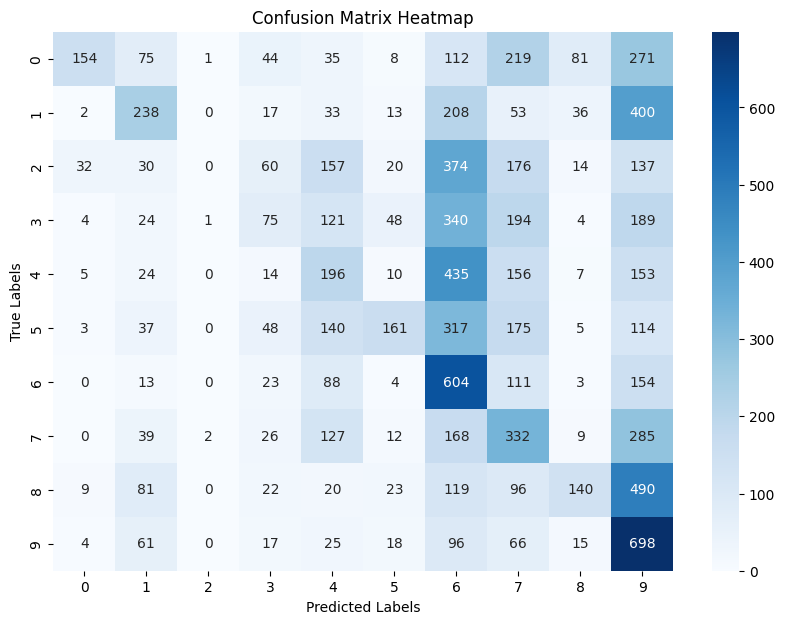

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_mat = confusion_matrix(all_labels, pred_classes)

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


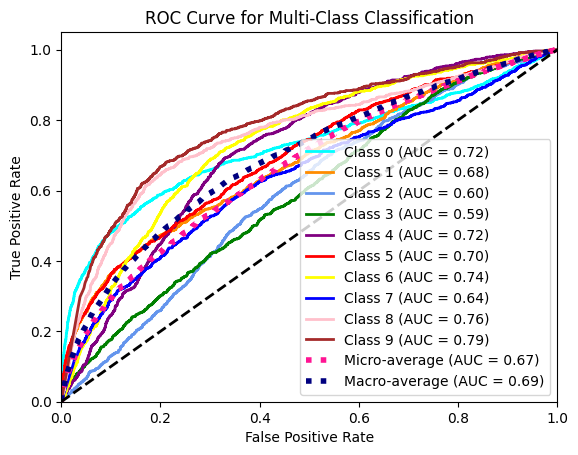

Micro-average AUC: 0.6671
Macro-average AUC: 0.6935


In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

# Binarize the labels for multi-class ROC curve calculation
n_classes = opt.n_classes
labels_binarized = label_binarize(all_labels, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(labels_binarized.ravel(), all_preds.ravel())
micro_auc = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

# Plot ROC curve for each class
plt.figure()
colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "purple", "red", "yellow", "blue", "pink", "brown"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot micro and macro average ROC curve
plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', linewidth=4, label=f'Micro-average (AUC = {micro_auc:.2f})')
plt.plot(all_fpr, mean_tpr, color='navy', linestyle=':', linewidth=4, label=f'Macro-average (AUC = {macro_auc:.2f})')

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend(loc="lower right")
plt.show()

print(f"Micro-average AUC: {micro_auc:.4f}")
print(f"Macro-average AUC: {macro_auc:.4f}")


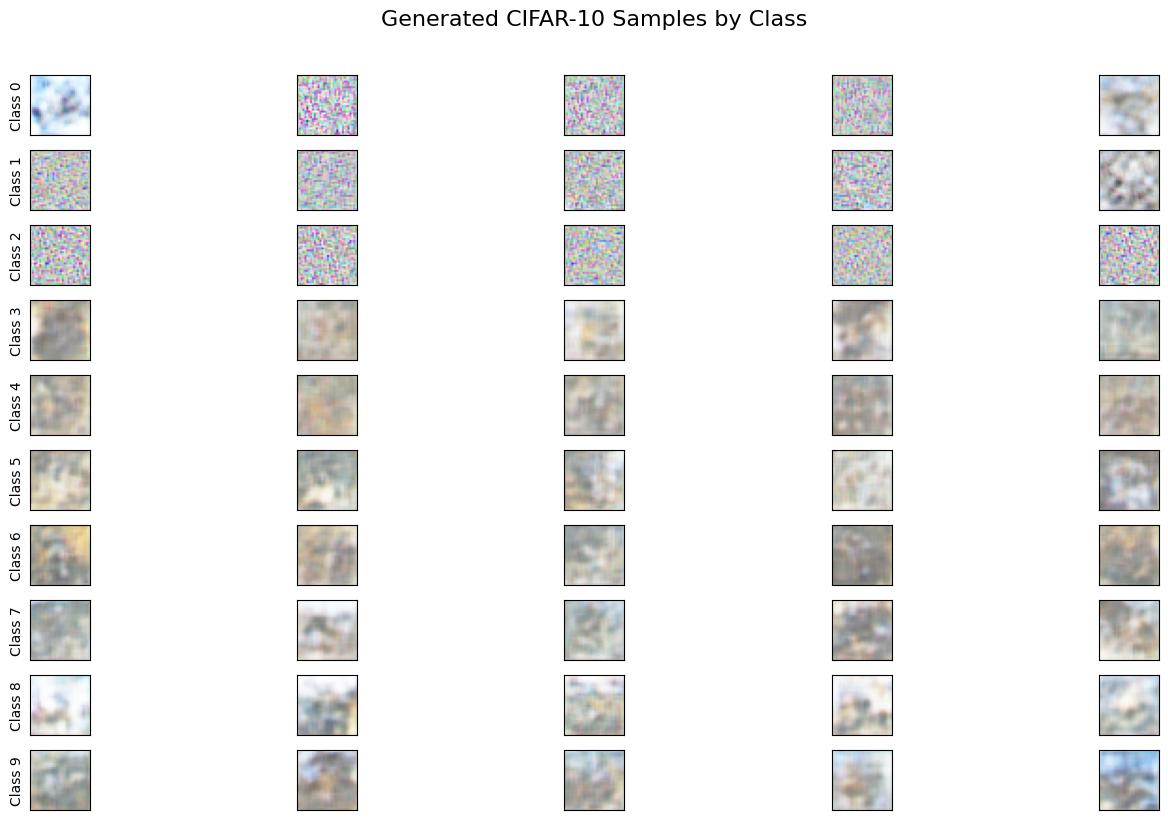

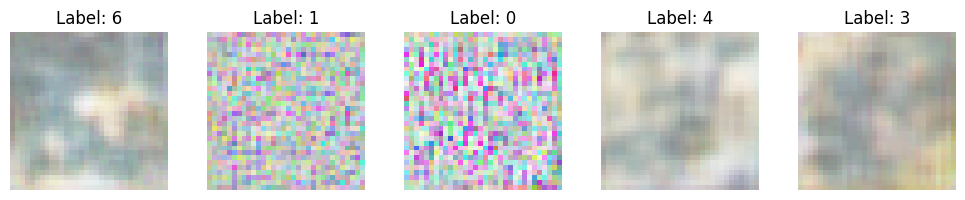

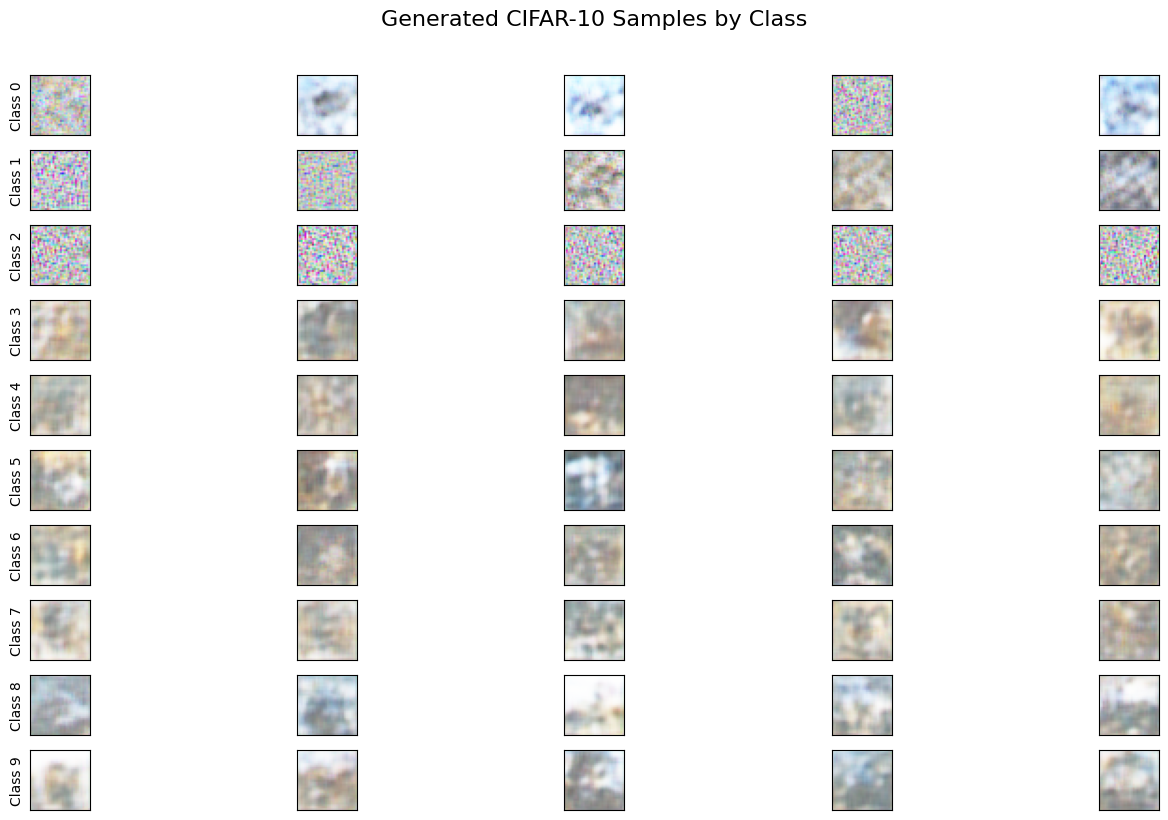

Predicted Labels by Discriminator:
[0 0 0 0 0 0 0 0 5 8 0 0 0 0 0 0 3 3 3 3 0 0 5 0 0 5 5 5 5 5 0 5 0 5 5 0 0
 0 0 0 8 0 8 8 8 0 8 8 8 8]


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def generate_and_display_samples(generator, num_samples=5, latent_dim=100, num_classes=10):
    """
    Generate and display samples from the conditional CIFAR-10 generator.

    Parameters:
    - generator: Trained generator model
    - num_samples: Number of samples to generate per class
    - latent_dim: Dimension of the latent noise vector
    - num_classes: Number of classes (10 for CIFAR-10)
    """
    # Set up the figure
    fig = plt.figure(figsize=(15, 8))
    total_samples = num_samples * num_classes

    # Set generator to evaluation mode
    generator.eval()

    # Get the device that the generator is on
    device = next(generator.parameters()).device

    # Generate samples for each class
    with torch.no_grad():
        # Create noise and labels
        z = torch.randn(total_samples, latent_dim, device=device)
        labels = torch.tensor(
            [i for i in range(num_classes) for _ in range(num_samples)],
            device=device
        )

        # Generate images
        generated_images = generator(z, labels)

        # Convert to numpy and scale to [0, 1]
        generated_images = (generated_images.cpu().numpy() * 0.5 + 0.5).transpose(0, 2, 3, 1)  # (N, C, H, W) → (N, H, W, C)

    # Display images
    for idx, img in enumerate(generated_images):
        ax = fig.add_subplot(num_classes, num_samples, idx + 1)
        plt.imshow(img)  # CIFAR-10 images are in RGB
        ax.set_xticks([])
        ax.set_yticks([])

        # Add label on first column
        if idx % num_samples == 0:
            ax.set_ylabel(f'Class {idx // num_samples}', fontsize=10)

    plt.suptitle('Generated CIFAR-10 Samples by Class', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    return generated_images, labels

def generate_specific_samples(generator, specific_labels, latent_dim=100):
    """
    Generate samples for specific labels in CIFAR-10.

    Parameters:
    - generator: Trained generator model
    - specific_labels: List of labels to generate samples for
    - latent_dim: Dimension of the latent noise vector
    """
    generator.eval()
    device = next(generator.parameters()).device
    num_samples = len(specific_labels)

    plt.figure(figsize=(num_samples * 2, 2))

    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim, device=device)
        labels = torch.tensor(specific_labels, device=device)

        generated_images = generator(z, labels)
        generated_images = (generated_images.cpu().numpy() * 0.5 + 0.5).transpose(0, 2, 3, 1)

    for idx, (img, label) in enumerate(zip(generated_images, specific_labels)):
        plt.subplot(1, num_samples, idx + 1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return generated_images, labels

def test_discriminator_on_generated(discriminator, generator, num_samples=5, latent_dim=100, num_classes=10):
    """
    Generate samples using the generator and classify them using the discriminator.

    Parameters:
    - discriminator: Trained discriminator model
    - generator: Trained generator model
    - num_samples: Number of samples to generate per class
    - latent_dim: Dimension of the latent noise vector
    - num_classes: Number of classes
    """
    generated_images, labels = generate_and_display_samples(generator, num_samples, latent_dim, num_classes)

    # Convert generated images to tensors
    generated_images = torch.tensor(generated_images, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to (N, C, H, W)

    device = next(discriminator.parameters()).device
    generated_images = generated_images.to(device)

    discriminator.eval()
    with torch.no_grad():
        _, predicted_labels = discriminator(generated_images)
        predicted_classes = torch.argmax(predicted_labels, dim=1).cpu().numpy()

    print("Predicted Labels by Discriminator:")
    print(predicted_classes)

# Example usage:
if __name__ == "__main__":
    # Generate samples for all classes
    generate_and_display_samples(generator, num_samples=5)

    # Generate specific samples
    specific_labels = [6, 1, 0, 4, 3]  # Generate these specific classes
    generate_specific_samples(generator, specific_labels)

    # Test discriminator on generated images
    test_discriminator_on_generated(discriminator, generator, num_samples=5)


In [ ]:
#Original code
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
#
os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=2, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=256, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=16, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--n_classes", type=int, default=10, help="number of classes for dataset")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=200, help="interval between image sampling")
# The following line has been changed to not parse arguments from the command line
opt = parser.parse_args([]) # remove arguments from this list if you do intend to pass arguments
print(opt)
#
cuda = True if torch.cuda.is_available() else False


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(opt.n_classes, opt.latent_dim)

        self.init_size = opt.img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, opt.n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label


# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)


# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = discriminator(gen_imgs)
        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), 100 * d_acc, g_loss.item())
        )
        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)


Namespace(n_epochs=2, batch_size=256, lr=0.0002, b1=0.5, b2=0.999, n_cpu=16, latent_dim=100, n_classes=10, img_size=32, channels=1, sample_interval=800)
[Epoch 0/2] [Batch 0/235] [D loss: 1.497848, acc: 8%] [G loss: 1.496086]
[Epoch 0/2] [Batch 1/235] [D loss: 1.497714, acc: 10%] [G loss: 1.496256]
[Epoch 0/2] [Batch 2/235] [D loss: 1.497804, acc: 8%] [G loss: 1.496315]
[Epoch 0/2] [Batch 3/235] [D loss: 1.497758, acc: 9%] [G loss: 1.496561]
[Epoch 0/2] [Batch 4/235] [D loss: 1.497605, acc: 10%] [G loss: 1.496586]
[Epoch 0/2] [Batch 5/235] [D loss: 1.497725, acc: 7%] [G loss: 1.496982]
[Epoch 0/2] [Batch 6/235] [D loss: 1.497446, acc: 10%] [G loss: 1.496961]
[Epoch 0/2] [Batch 7/235] [D loss: 1.497414, acc: 9%] [G loss: 1.497184]
[Epoch 0/2] [Batch 8/235] [D loss: 1.497265, acc: 10%] [G loss: 1.497039]
[Epoch 0/2] [Batch 9/235] [D loss: 1.497218, acc: 9%] [G loss: 1.497303]
[Epoch 0/2] [Batch 10/235] [D loss: 1.497149, acc: 8%] [G loss: 1.497442]
[Epoch 0/2] [Batch 11/235] [D loss: 1.4